# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

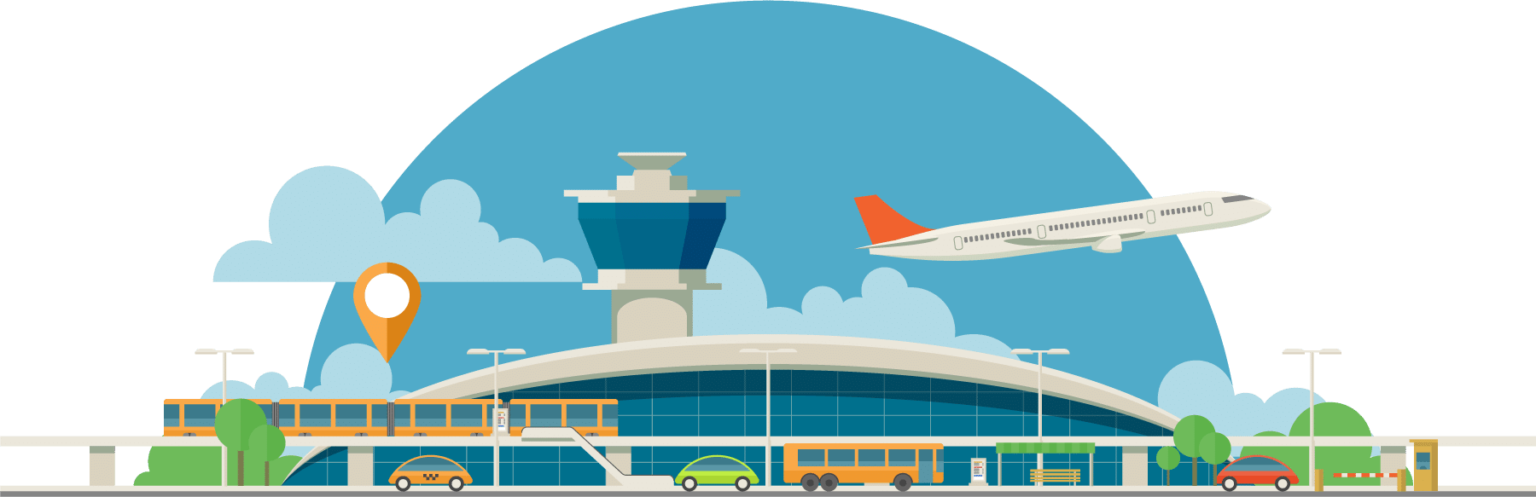

In [6]:
# установка всех библиотек, необходимых для выполнения ДЗ

#!pip3 install catboost
#!pip3 install mlxtend --upgrade
#!pip3 install optuna
#!pip3 install lime
#!pip3 install shap
#!pip3 install missingno
#!pip3 install psycopg2-binary
#!pip3 install xgboost
#!brew install cmake libomp
#!pip3 install lightgbm

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
#from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [10]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

zsh:1: command not found: wget


### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

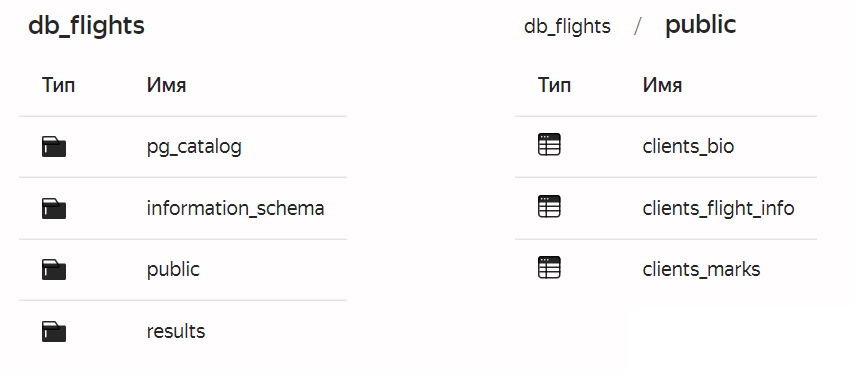



In [11]:
conn_params = ("""
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write
""")

sql_query = 'SELECT * FROM clients_bio JOIN clients_flight_info ON clients_bio.id = clients_flight_info.id JOIN clients_marks ON clients_flight_info.id = clients_marks.id;'

with psycopg2.connect(conn_params) as conn:
    df = pd.read_sql(sql_query, conn)


/var/folders/61/dxx6y9856fb6yzjbg9g92kv40000gn/T/ipykernel_2262/122138666.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


In [12]:
df = df.loc[:,~df.columns.duplicated()].copy()

In [13]:
df.set_index('id', inplace=True)
df.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                          ...   
7                    3.0                               3.0  ...   
13                   2.0                               2.0  ...   
18                   2.0                               5.0  ...   
31                   2.0                               2.0  ...   
39                   3.0                               3.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                        
7              4.0          5.0                    5.0              5.0   
13             2.0          5.0                    5.0              2.0   
18             1.0          5.0                    5.0              5.0   
31             2.0          2.0                    2.0              4.0   
39             5.0          4.0                    4.0              4.0   

   Leg room service Baggage handling Checkin service Inflight service  \
id                                                                      
7               5.0              5.0             4.0              5.0   
13              4.0              4.0             2.0              4.0   
18              2.0              5.0             5.0              5.0   
31              5.0              5.0             5.0              4.0   
39              4.0              4.0             5.0              4.0   

   cleanliness             satisfaction  
id                                       
7          4.0                satisfied  
13         5.0  neutral or dissatisfied  
18         1.0  neutral or dissatisfied  
31         2.0  neutral or dissatisfied  
39         5.0                satisfied  

[5 rows x 23 columns]

In [14]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [15]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129549 non-null  object
 2   Customer Type                      129549 non-null  object
 3   Type of Travel                     129549 non-null  object
 4   class                              129549 non-null  object
 5   Flight Distance                    129549 non-null  object
 6   Departure Delay in Minutes         129549 non-null  object
 7   Arrival Delay in Minutes           129549 non-null  object
 8   Inflight wifi service              129549 non-null  object
 9   Departure/Arrival time convenient  129549 non-null  object
 10  Ease of Online booking             129549 non-null  object
 11  Gate location                      129549 non-null  objec

In [16]:
cols = df.drop(columns=['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction']).columns
dff = df.copy()
dff[cols] = dff[cols].apply(pd.to_numeric, errors='coerce')
dff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129549 non-null  object 
 3   Type of Travel                     129549 non-null  object 
 4   class                              129549 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      129512 no

In [17]:
dff['gender'].value_counts()


gender
Female    65726
Male      63823
Name: count, dtype: int64

In [18]:
dff['Customer Type'].value_counts()

Customer Type
Loyal Customer       105763
disloyal Customer     23709
nan                      77
Name: count, dtype: int64

In [19]:
dff['Type of Travel'].value_counts()

Type of Travel
Business travel    89405
Personal Travel    40043
nan                  101
Name: count, dtype: int64

In [20]:
dff['class'].value_counts()

class
Business    61939
Eco         58115
Eco Plus     9379
nan           116
Name: count, dtype: int64

In [21]:
dff['satisfaction'].value_counts()

satisfaction
neutral or dissatisfied    58732
satisfied                  44912
-                          25905
Name: count, dtype: int64

In [22]:
cols = ['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction']
dff[cols] = dff[cols].replace('nan', pd.NA)
dff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129472 non-null  object 
 3   Type of Travel                     129448 non-null  object 
 4   class                              129433 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      129512 no

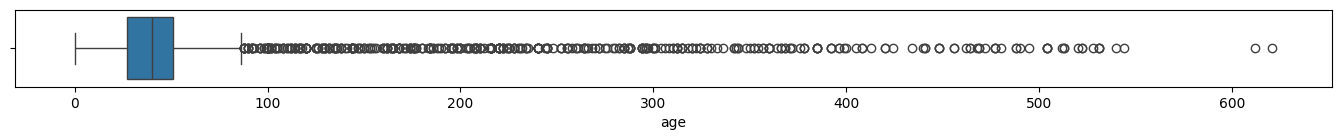

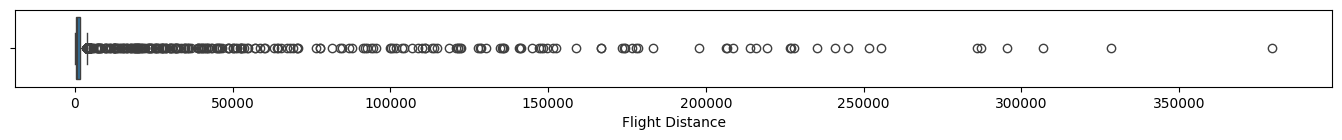

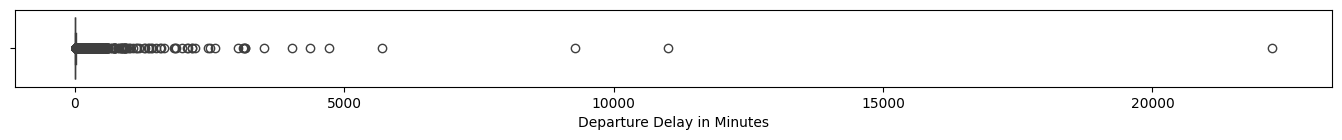

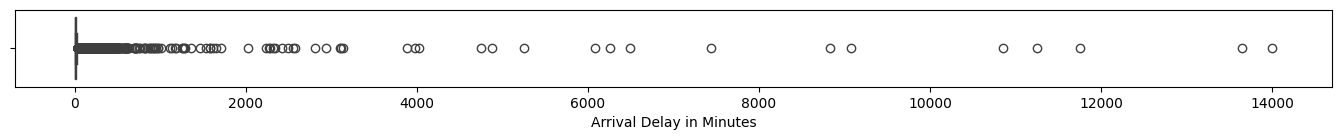

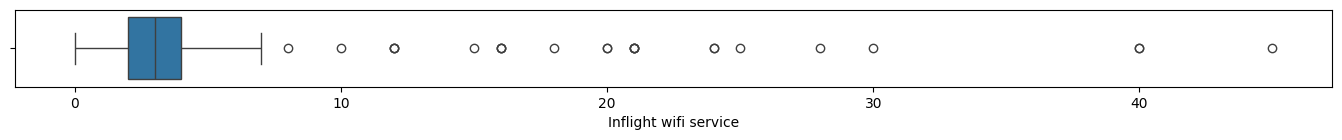

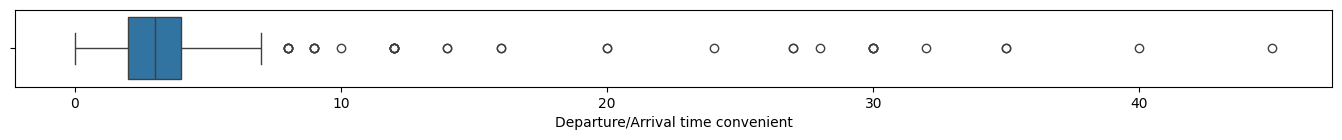

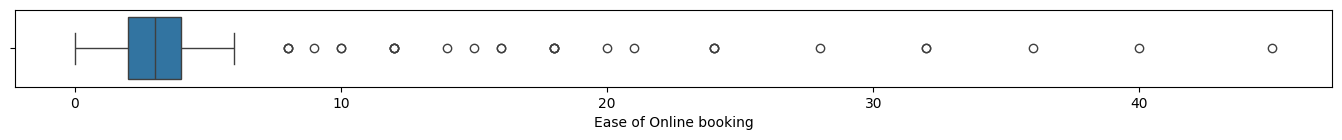

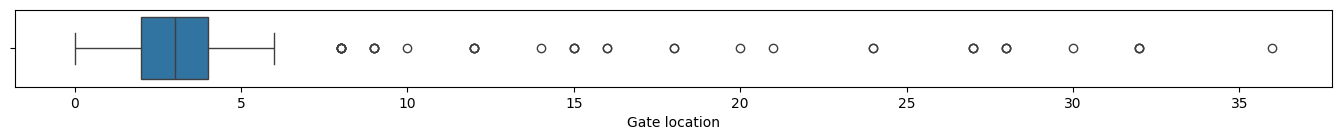

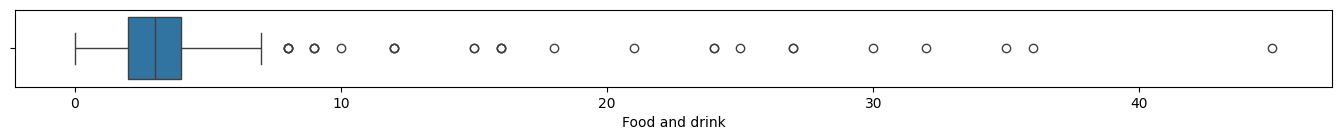

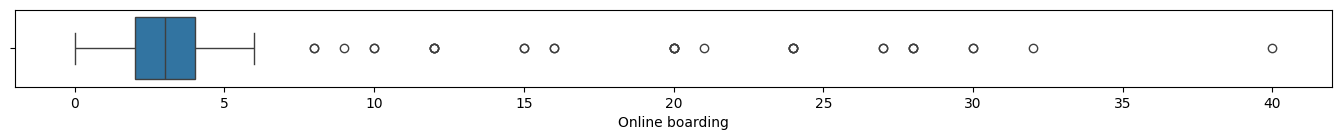

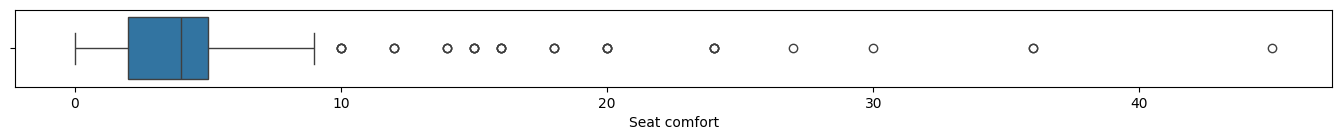

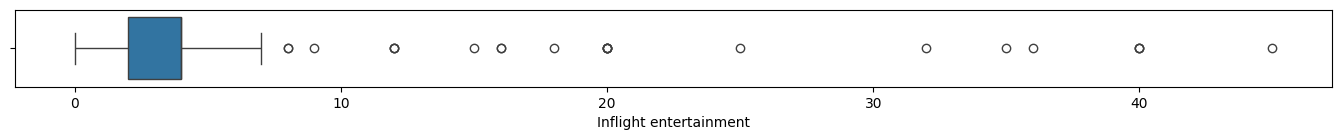

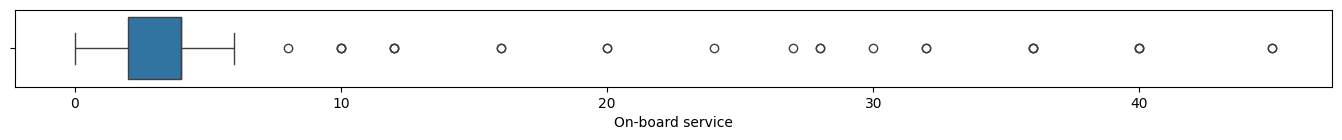

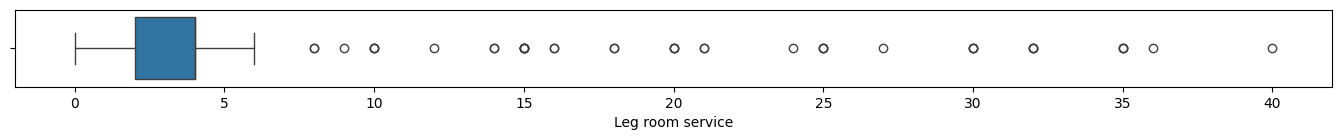

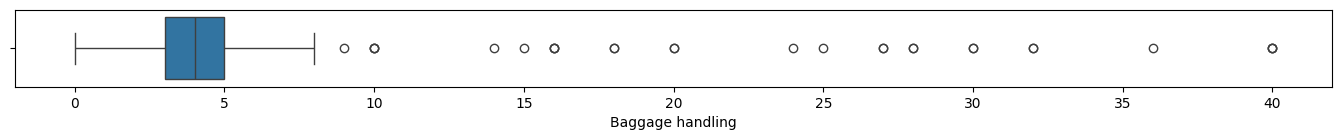

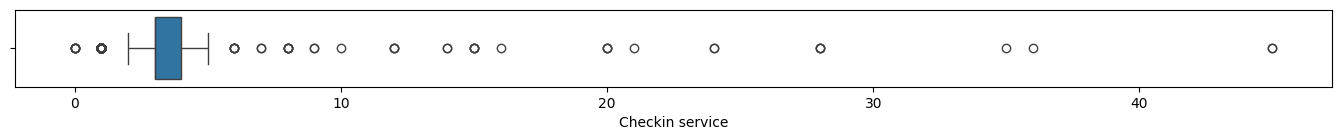

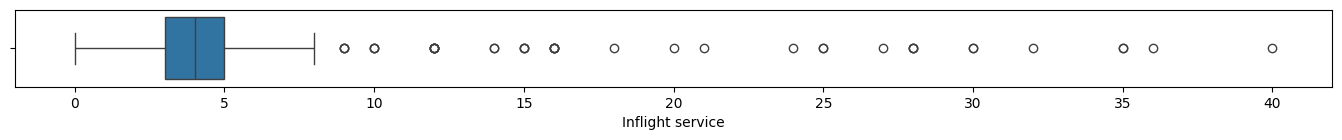

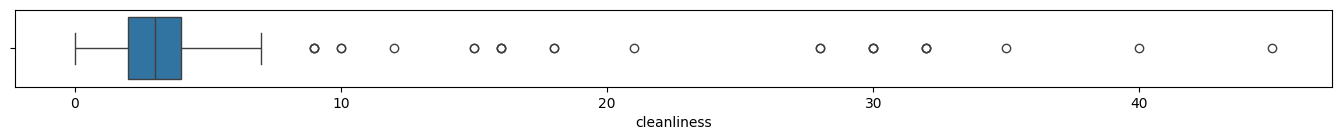

In [23]:
df_boxplot = dff.select_dtypes(exclude=['object'])
for column in df_boxplot:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=df_boxplot, x=column)


### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Axes: >

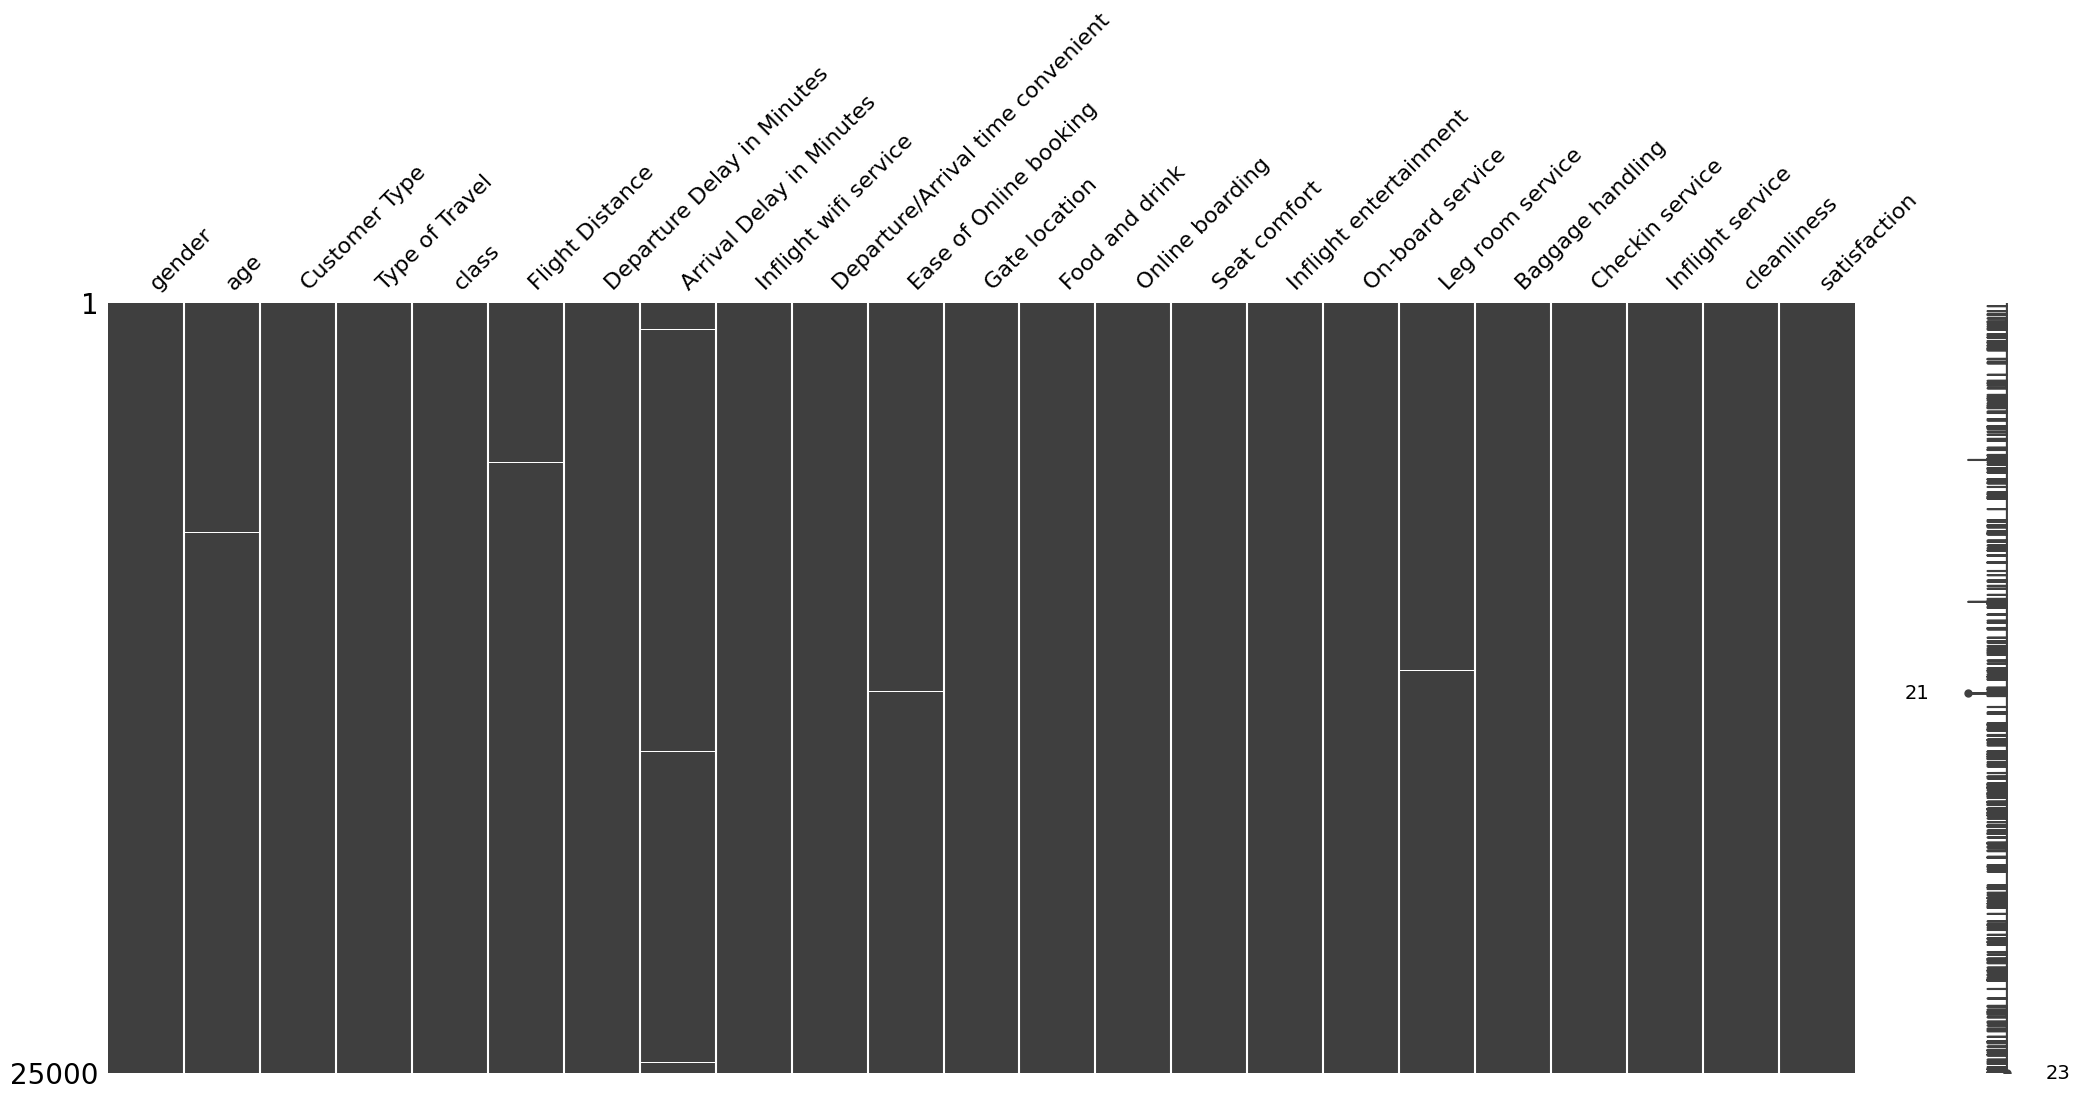

In [24]:
missingno.matrix(dff.sample(25000))

/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


<Axes: >

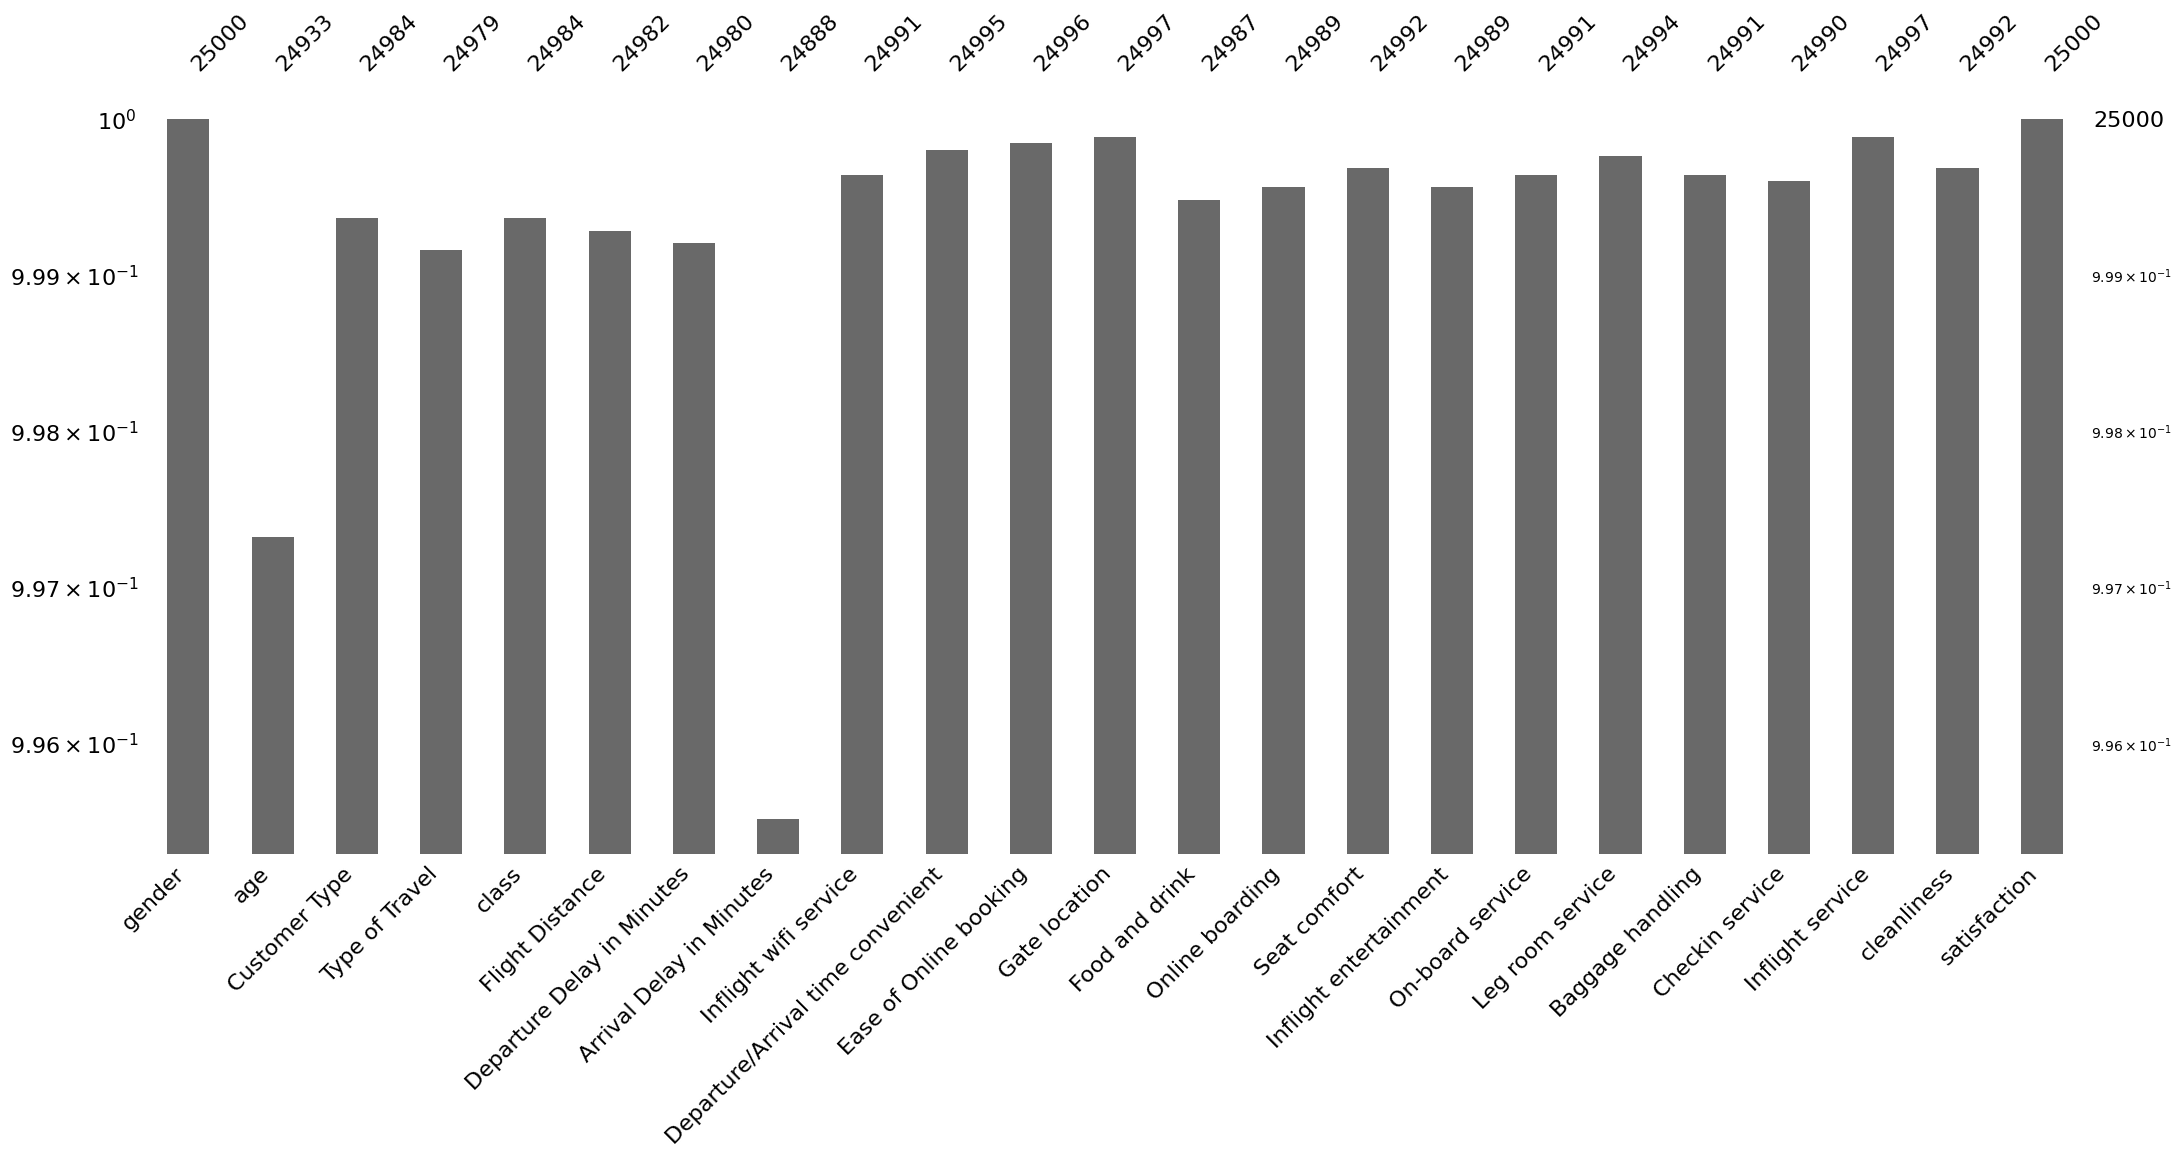

In [25]:
missingno.bar(dff.sample(25000),log=True)


Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [26]:
df_train = dff[dff.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
7                         3.0                                3.0  ...   
13                        2.0                                2.0  ...   
18                        2.0                                5.0  ...   
31                        2.0                                2.0  ...   
39                        3.0                                3.0  ...   
...                       ...                                ...  ...   
129831                    1.0                                3.0  ...   
129837                    2.0                                4.0  ...   
129838                    3.0                                5.0  ...   
129839                    2.0                                4.0  ...   
129846                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129831              1.0           3.0                     3.0   
129837              5.0           5.0                     5.0   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13  

In [27]:
assert df_train.shape == (103_644, 23)

In [28]:
df_test = dff[dff.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
55                        1.0                                1.0  ...   
79                        5.0                                4.0  ...   
126                       2.0                                5.0  ...   
199                       4.0                                4.0  ...   
263                       1.0                                2.0  ...   
...                       ...                                ...  ...   
129750                    4.0                                3.0  ...   
129771                    3.0                                4.0  ...   
129798                    2.0                                4.0  ...   
129868                    3.0                                4.0  ...   
129876                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
55                 1.0              3.0           3.0                     3.0   
79                 4.0              4.0           4.0                     3.0   
126                5.0              2.0           5.0                     5.0   
199                2.0              4.0           5.0                     4.0   
263                2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129750             4.0              5.0           4.0                     4.0   
129771             1.0              3.0           5.0                     1.0   
129798             3.0              5.0           5.0                     4.0   
129868             4.0              3.0           4.0                     4.0   
129876             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service 

In [29]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [30]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [31]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [32]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_val = X_val.fillna(X_train.mode().iloc[0])

In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72550 entries, 2031 to 28513
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             72550 non-null  object 
 1   age                                72550 non-null  float64
 2   Customer Type                      72550 non-null  object 
 3   Type of Travel                     72550 non-null  object 
 4   class                              72550 non-null  object 
 5   Flight Distance                    72550 non-null  float64
 6   Departure Delay in Minutes         72550 non-null  float64
 7   Arrival Delay in Minutes           72550 non-null  float64
 8   Inflight wifi service              72550 non-null  float64
 9   Departure/Arrival time convenient  72550 non-null  float64
 10  Ease of Online booking             72550 non-null  float64
 11  Gate location                      72550 non-null  float

In [34]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31094 entries, 62191 to 122474
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             31094 non-null  object 
 1   age                                31094 non-null  float64
 2   Customer Type                      31094 non-null  object 
 3   Type of Travel                     31094 non-null  object 
 4   class                              31094 non-null  object 
 5   Flight Distance                    31094 non-null  float64
 6   Departure Delay in Minutes         31094 non-null  float64
 7   Arrival Delay in Minutes           31094 non-null  float64
 8   Inflight wifi service              31094 non-null  float64
 9   Departure/Arrival time convenient  31094 non-null  float64
 10  Ease of Online booking             31094 non-null  float64
 11  Gate location                      31094 non-null  flo

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [35]:
X_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.098856      1329.018332                   15.859366   
std       20.658196      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                11760.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.065017                2.761006   
std                             1.552254                1.414843   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               28.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.982688        3.209318         3.256513      3.445665   
std         1.316648        1.349963         1.372739      1.346077   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       36.000000        32.000000     45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362150          3.383101          3.352364   
std                  1.360862          1.333758          1.360180   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         36.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.630255         3.309056          3.640234      3.291178  
std            1.227853         1.293114          1.215114      1.343302  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

In [36]:
X_train.describe(include=[object])

gender   Customer Type   Type of Travel     class
count    72550           72550            72550     72550
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36816           59406            50054     34793

`Распределение признаков на первый взгляд выглядит стандартно и равномерно. Но есть выбросы, которые завышают среднее значение и значение стандартного отклонения`




### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [37]:
cols = df.drop(columns=['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction']).columns
q_max = X_train[cols].quantile(0.996)
X_train = X_train[(X_train[cols] <= q_max).all(axis=1)]

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71395 entries, 2031 to 28513
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             71395 non-null  object 
 1   age                                71395 non-null  float64
 2   Customer Type                      71395 non-null  object 
 3   Type of Travel                     71395 non-null  object 
 4   class                              71395 non-null  object 
 5   Flight Distance                    71395 non-null  float64
 6   Departure Delay in Minutes         71395 non-null  float64
 7   Arrival Delay in Minutes           71395 non-null  float64
 8   Inflight wifi service              71395 non-null  float64
 9   Departure/Arrival time convenient  71395 non-null  float64
 10  Ease of Online booking             71395 non-null  float64
 11  Gate location                      71395 non-null  float

In [39]:
X_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  71395.000000     71395.000000                71395.000000   
mean      39.379676      1180.327110                   13.560081   
std       15.103008       987.084943                   30.672384   
min        0.000000         0.000000                    0.000000   
25%       27.000000       409.000000                    0.000000   
50%       40.000000       837.000000                    0.000000   
75%       51.000000      1729.000000                   12.000000   
max       80.000000      3980.000000                  265.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              71395.000000           71395.000000   
mean                  13.845101               2.729827   
std                   31.043846               1.329804   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                  270.000000               5.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       71395.000000            71395.000000   
mean                            3.061895                2.757168   
std                             1.524972                1.399303   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                             5.000000                5.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   71395.000000    71395.000000     71395.000000  71395.000000   
mean        2.977744        3.206401         3.252343      3.440885   
std         1.277994        1.329861         1.349783      1.317559   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max         5.000000        5.000000         5.000000      5.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            71395.000000      71395.000000      71395.000000   
mean                 3.358232          3.379102          3.344842   
std                  1.334222          1.289210          1.317095   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                  5.000000          5.000000          5.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      71395.000000     71395.000000      71395.000000  71395.000000  
mean           3.625310         3.304895          3.637608      3.286631  
std            1.185203         1.267415          1.177825      1.312965  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max            5.000000         5.000000          5.000000      5.000000

In [40]:
q_max = X_val[cols].quantile(0.996)
X_val = X_val[(X_val[cols] <= q_max).all(axis=1)]

In [41]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30588 entries, 62191 to 122474
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             30588 non-null  object 
 1   age                                30588 non-null  float64
 2   Customer Type                      30588 non-null  object 
 3   Type of Travel                     30588 non-null  object 
 4   class                              30588 non-null  object 
 5   Flight Distance                    30588 non-null  float64
 6   Departure Delay in Minutes         30588 non-null  float64
 7   Arrival Delay in Minutes           30588 non-null  float64
 8   Inflight wifi service              30588 non-null  float64
 9   Departure/Arrival time convenient  30588 non-null  float64
 10  Ease of Online booking             30588 non-null  float64
 11  Gate location                      30588 non-null  flo

In [42]:
X_val.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  30588.000000     30588.000000                30588.000000   
mean      39.330979      1183.884563                   13.354387   
std       15.166116       989.889194                   30.655132   
min        0.000000         0.000000                    0.000000   
25%       27.000000       416.000000                    0.000000   
50%       40.000000       838.000000                    0.000000   
75%       51.000000      1737.000000                   12.000000   
max       80.000000      3977.000000                  264.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              30588.000000           30588.000000   
mean                  13.644566               2.727083   
std                   30.979311               1.323845   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   12.000000               4.000000   
max                  263.000000               5.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       30588.000000            30588.000000   
mean                            3.057800                2.753106   
std                             1.527099                1.397206   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                             5.000000                5.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   30588.000000    30588.000000     30588.000000  30588.000000   
mean        2.975121        3.191742         3.240127      3.431836   
std         1.275424        1.328808         1.350078      1.323217   
min         1.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max         5.000000        5.000000         5.000000      5.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            30588.000000      30588.000000      30588.000000   
mean                 3.355728          3.389466          3.360141   
std                  1.331560          1.284863          1.313643   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                  5.000000          5.000000          5.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      30588.000000     30588.000000      30588.000000  30588.000000  
mean           3.644370         3.299693          3.653884      3.281319  
std            1.171716         1.260931          1.167120      1.310598  
min            1.000000         0.000000          1.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max            5.000000         5.000000          5.000000      5.000000

In [43]:
assert df_test.shape == (25_905, 22)

In [44]:
y_train = y_train[X_train.index]
y_val = y_val[X_val.index]

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [45]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(dff.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(dff.select_dtypes(include='object').columns)[:-1]

In [46]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [47]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=df[col], hue=y, palette="husl")
        plt.title(f"Распределение {col} по таргету")
        plt.xlabel(col)
        plt.ylabel("Количество")
        plt.legend(title="Таргет")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()



In [48]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    df = df.copy()
    df["Target"] = y

    for col in cols:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        sns.histplot(data=df, x=col, kde=True, hue="Target", palette="husl", ax=axes[0])
        axes[0].set_title(f"Гистограмма распределения {col}")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("Плотность")
        axes[0].grid(axis='y', linestyle='--', alpha=0.7)

        sns.boxplot(data=df, x="Target", y=col, hue="Target", palette="Set2", ax=axes[1])
        axes[1].set_title(f"Ящик с усами {col} по таргету")
        axes[1].set_xlabel("Таргет")
        axes[1].set_ylabel(col)
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)

        plt.show()

In [49]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=df[col], hue=y, palette="husl")
        plt.title(f"Распределение {col} по таргету")
        plt.xlabel(col)
        plt.ylabel("К-во")
        plt.legend(title="Таргет")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

Отрисовка.

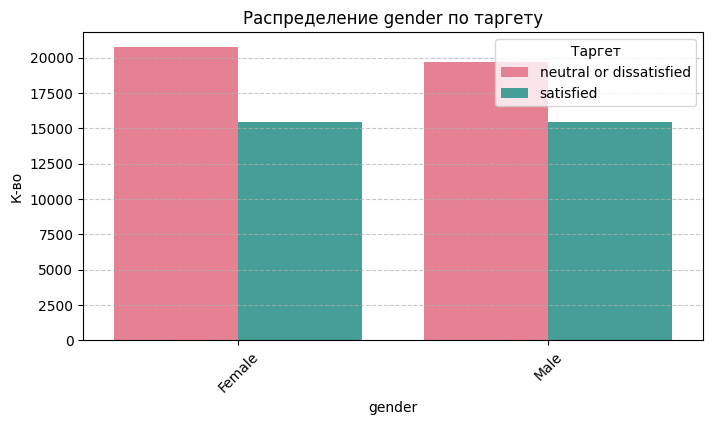

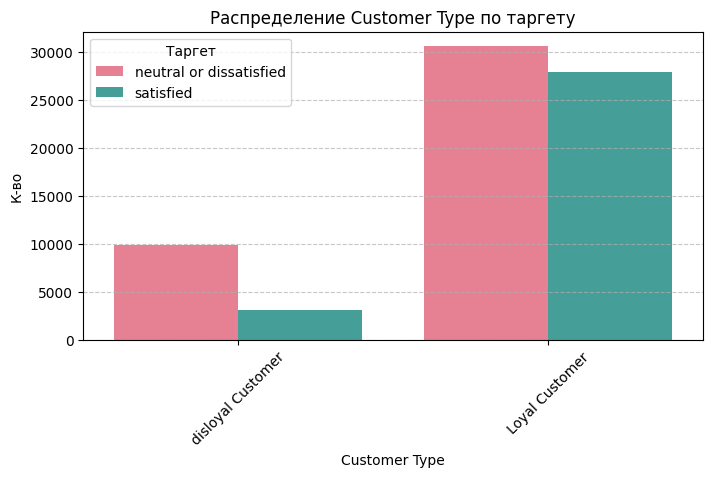

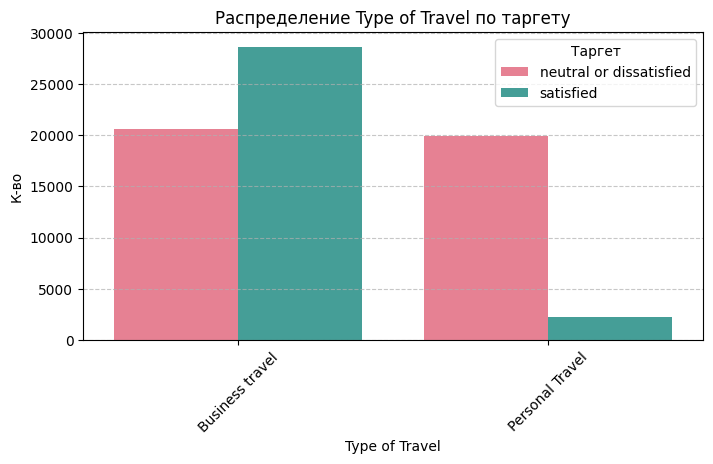

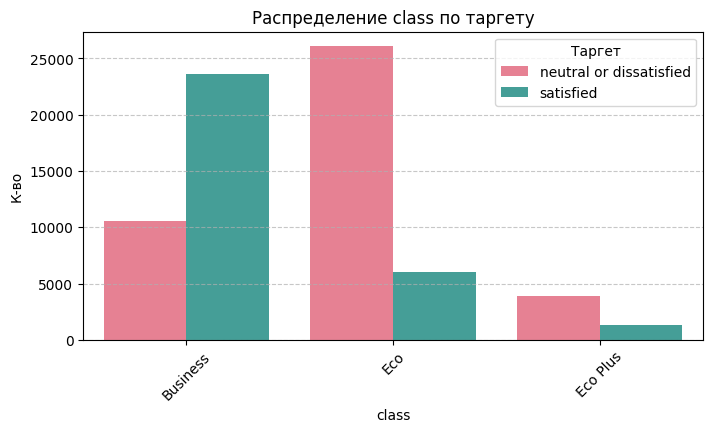

In [50]:
plot_categorical(categorical_cols, X_train, y_train)

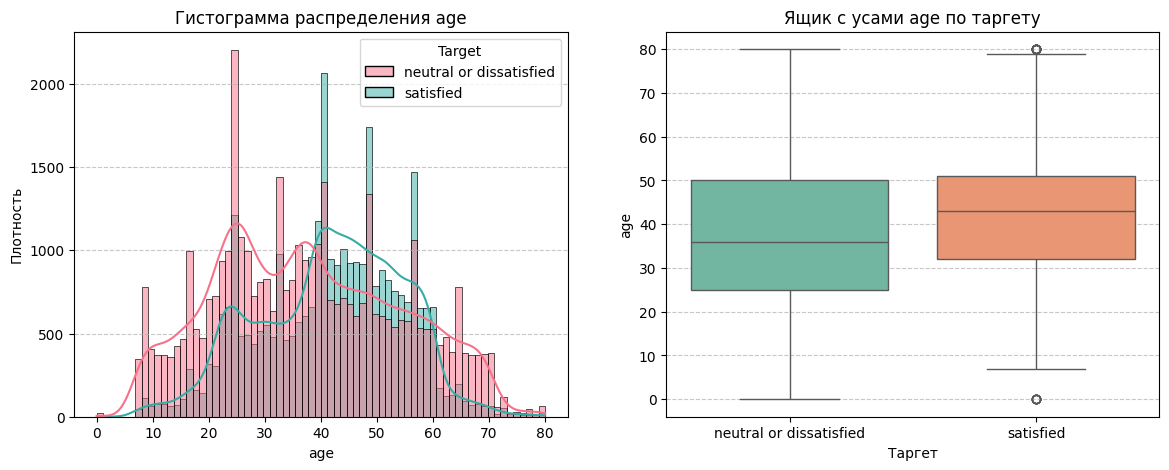

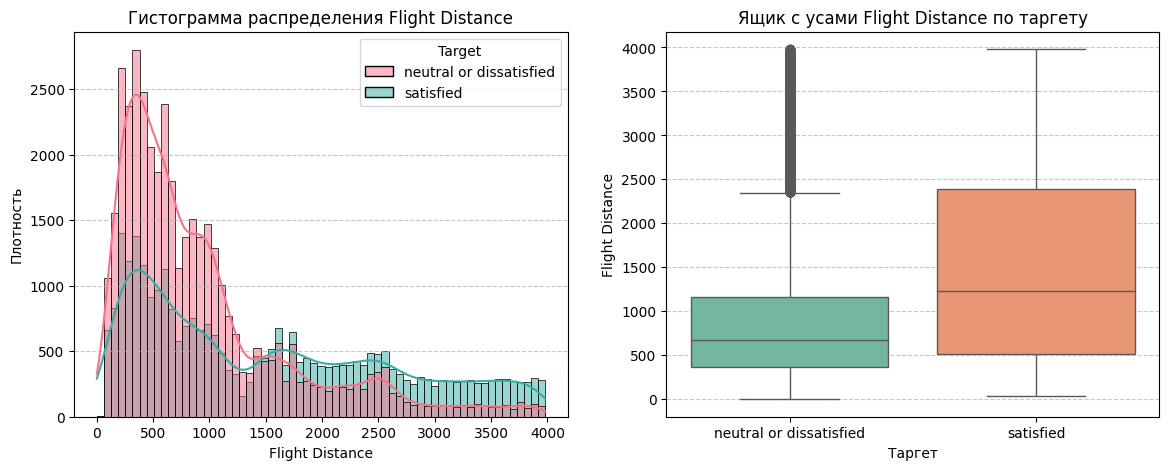

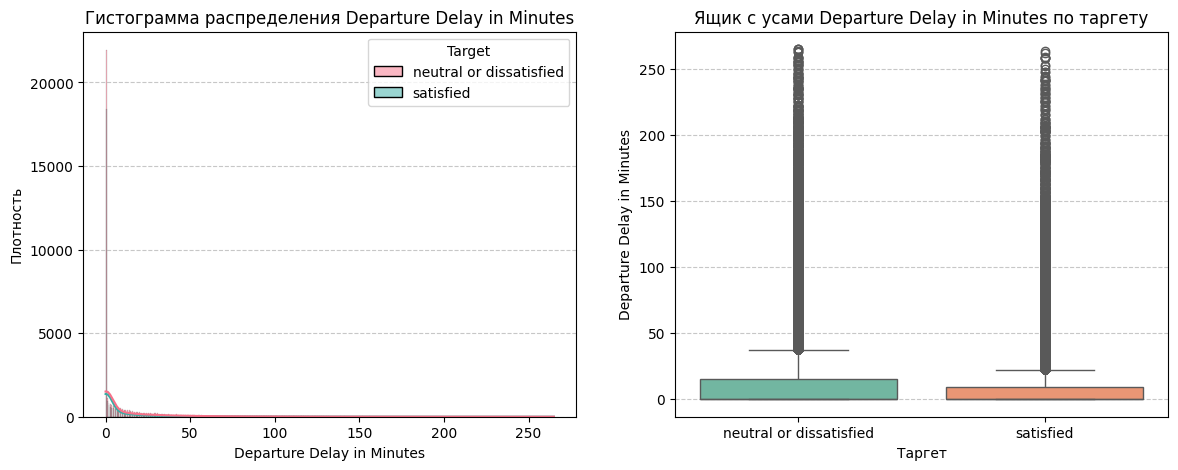

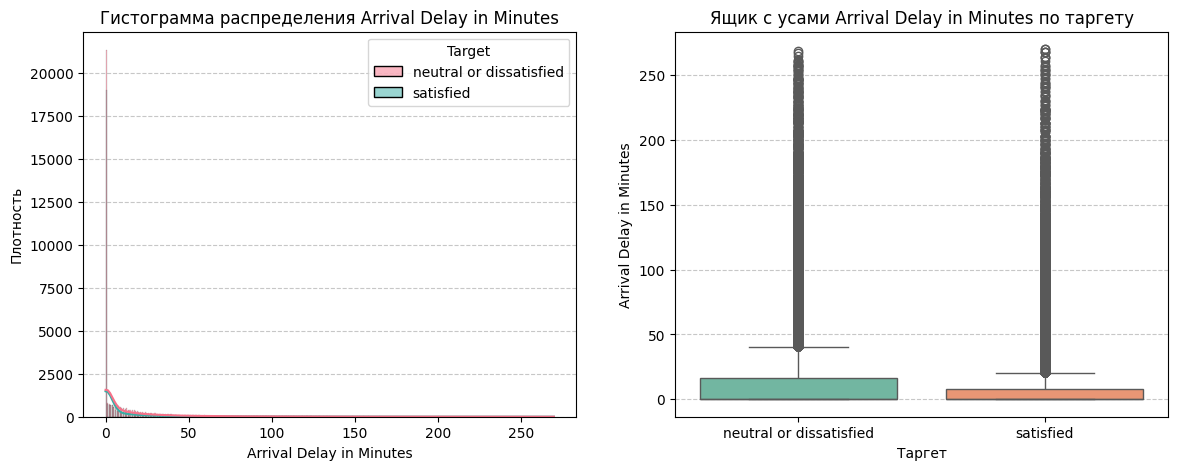

In [51]:
plot_continuous(continuous_cols, X_train, y_train)

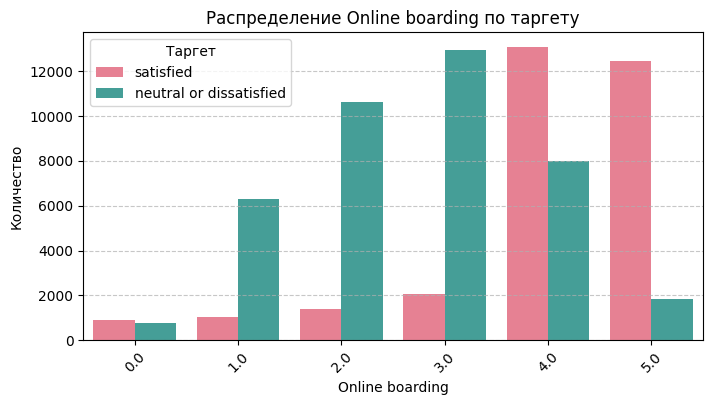

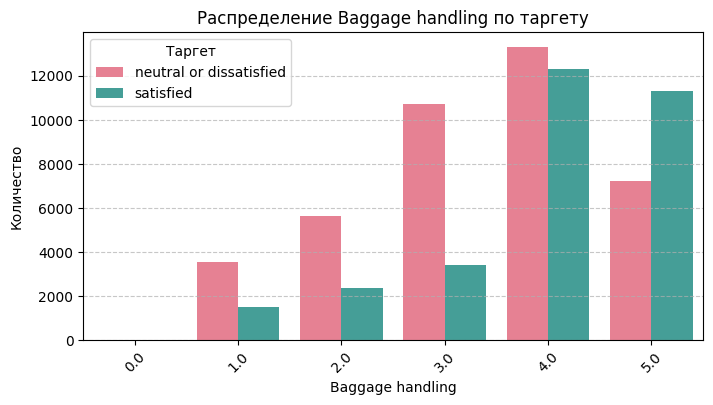

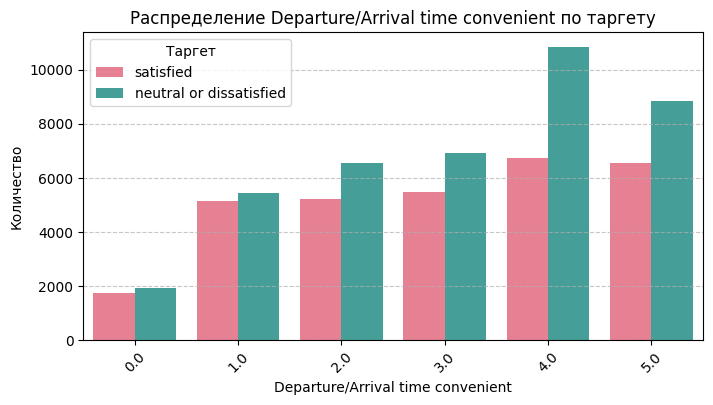

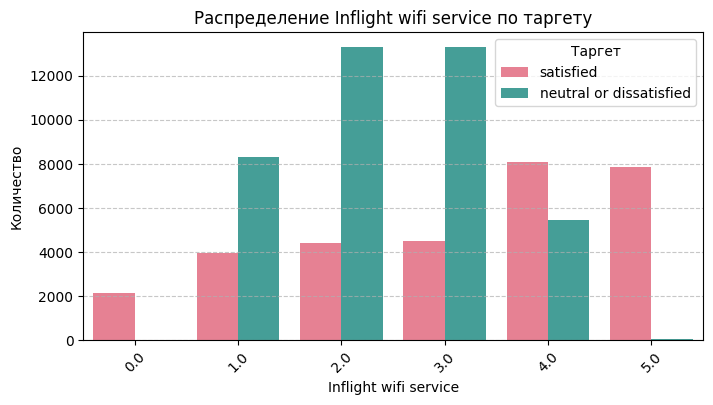

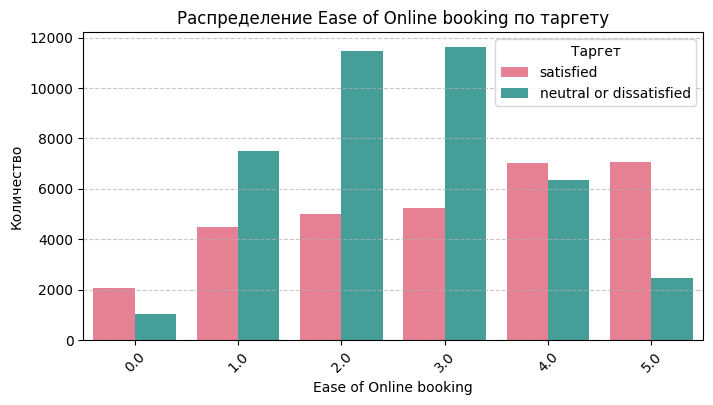

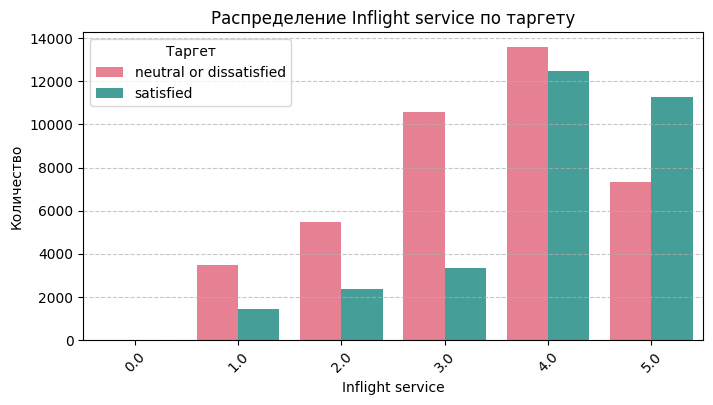

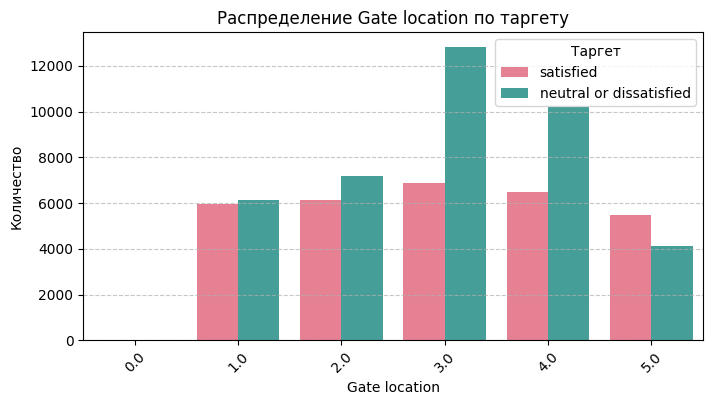

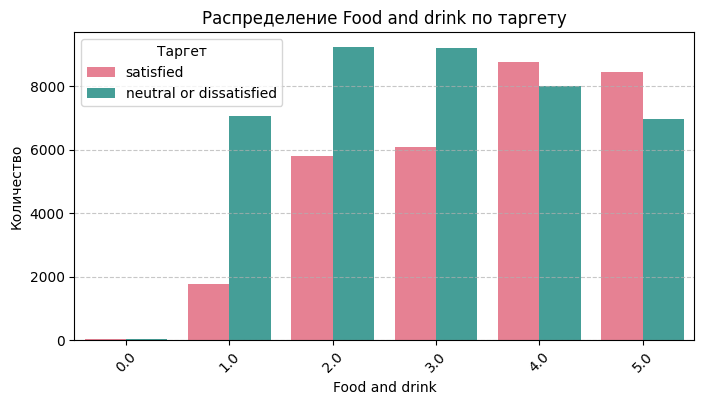

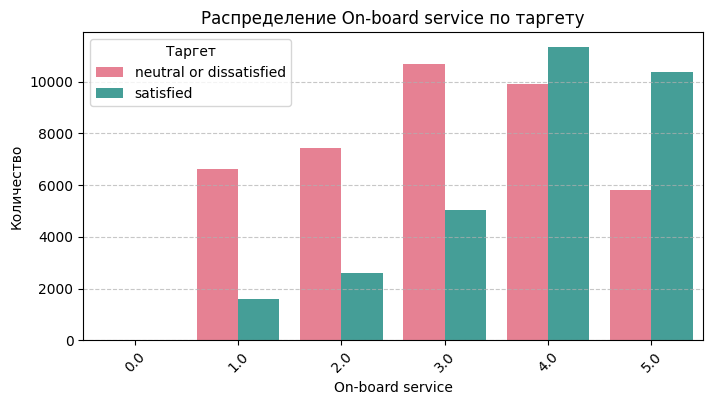

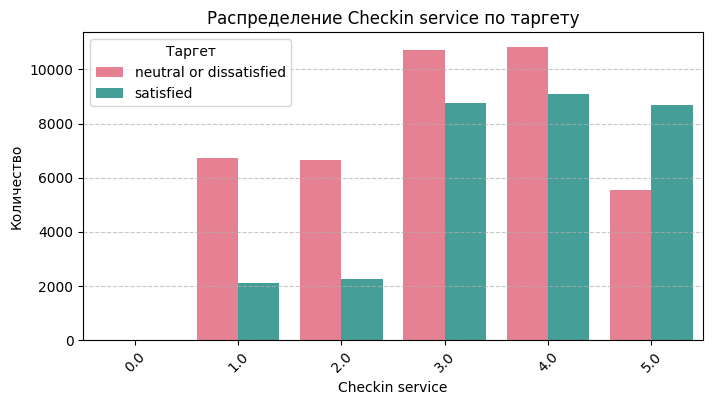

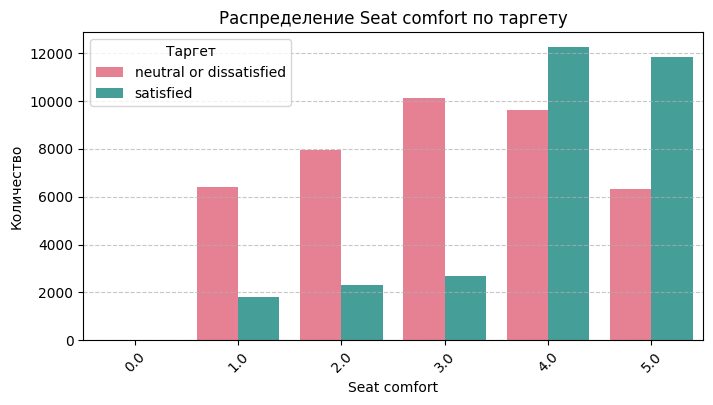

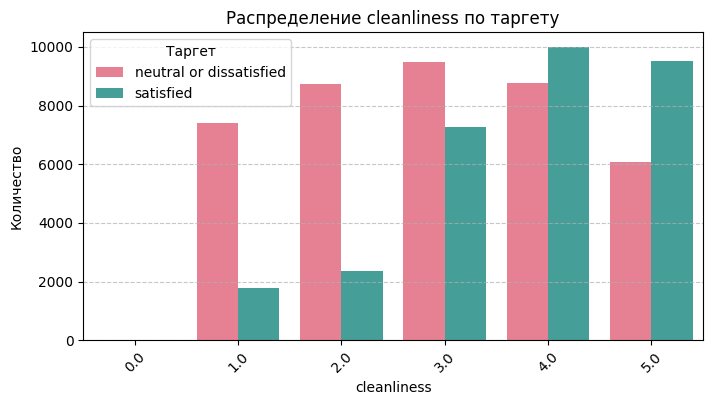

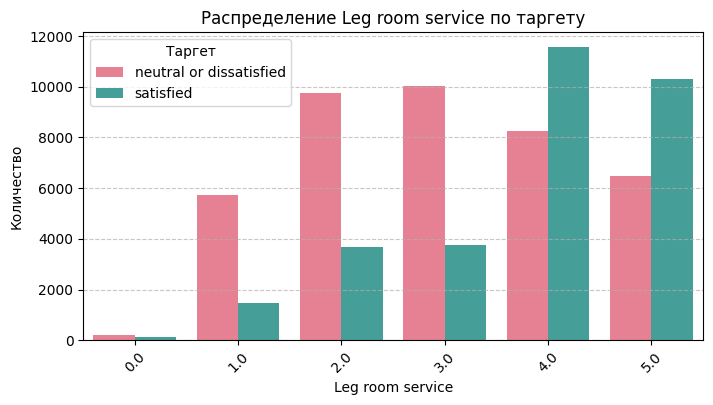

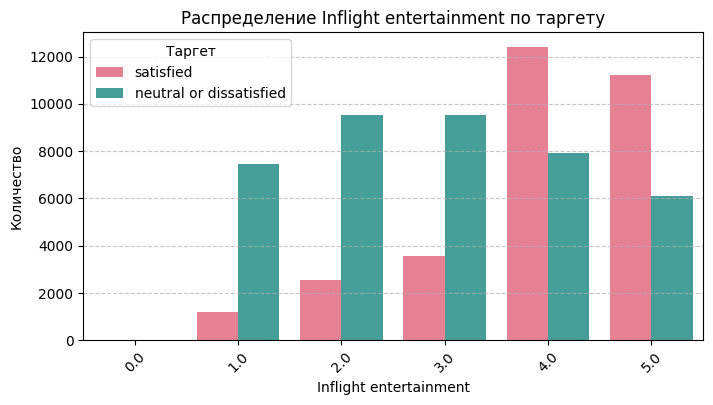

In [52]:
plot_ordinal(ordinal_cols, X_train, y_train)

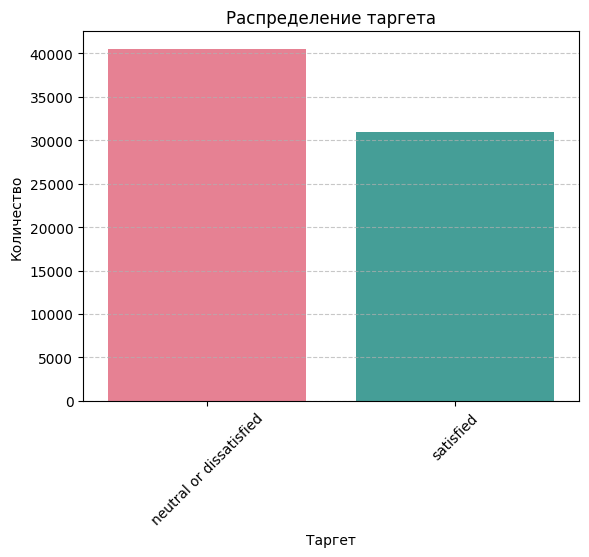

In [53]:
# visualize y_train
sns.countplot(x=y_train, hue=y_train, palette="husl")
plt.title(f"Распределение таргета")
plt.xlabel("Таргет")
plt.ylabel("Количество")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки


```
- Неравномерное распределение: Departure delay и arrival delay, class, customer type, type of travel
- Классы имеют небольшой дислабанс в сторону neutral or dissatisfied
– age близок к нормальному распределению
– flight distance похож на логнормальное рапределение или распределение со смещением влево
– Departure delay и arrival delay похожи на экспоненциальное рапределение, но огромное к-во нулевых значений говорят о том, что их следует рассматривать в логарифмированном виде
```



### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

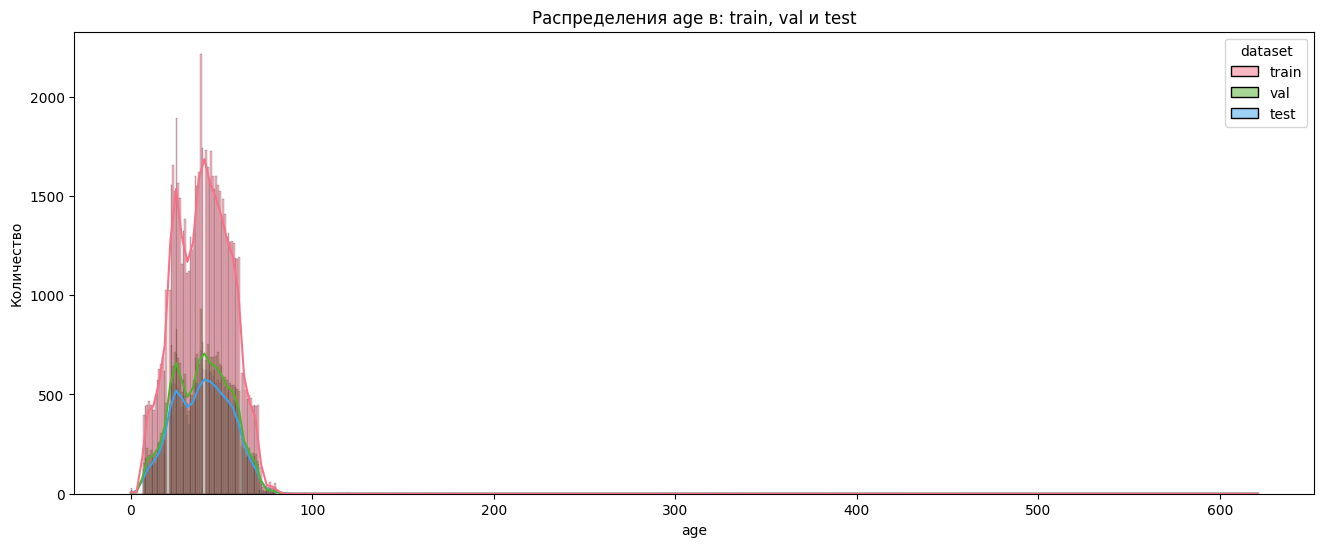

In [54]:
concatenated = pd.concat([X_train[['age']].assign(dataset='train'), X_val[['age']].assign(dataset='val'), df_test[['age']].assign(dataset='test')])
plt.figure(figsize=(16, 6))
plt.title(f"Распределения age в: train, val и test")
plt.xlabel("age")
plt.ylabel("Количество")
sns.histplot(data=concatenated, x='age', kde=True, hue="dataset", palette="husl")
plt.show()



```
Распределения похожи, если не учитывать, что из теста мы не удаляли выбросы
```



### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [55]:
# Есть несколько способов избежать -inf после логарифмирования 0.
# Можно добавить небольшое epsilon к 0, но тогда у нас будет большое отрицательное значение после логарифмирования вместо 0.
# Можно логарифмировать все положительные значения, кроме нулей, а можно добавить единицу ко всем значениям.
# log1p по сути добавляет единицу к значениям, я выбрал этот способ.

X_train['Departure Delay in Minutes'] = np.log1p(X_train['Departure Delay in Minutes'])
X_train['Arrival Delay in Minutes'] = np.log1p(X_train['Arrival Delay in Minutes'])

In [56]:
X_val['Departure Delay in Minutes'] = np.log1p(X_val['Departure Delay in Minutes'])
X_val['Arrival Delay in Minutes'] = np.log1p(X_val['Arrival Delay in Minutes'])

Построение.

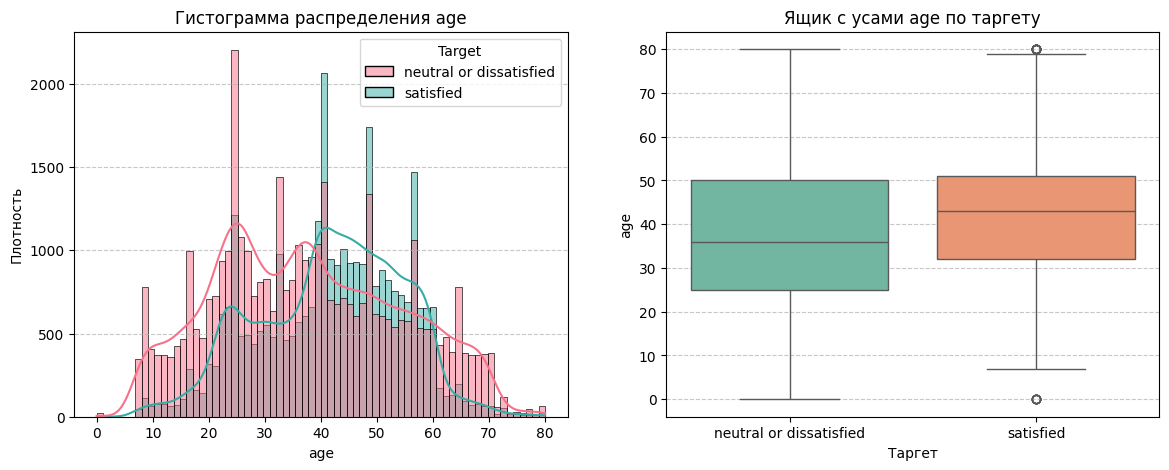

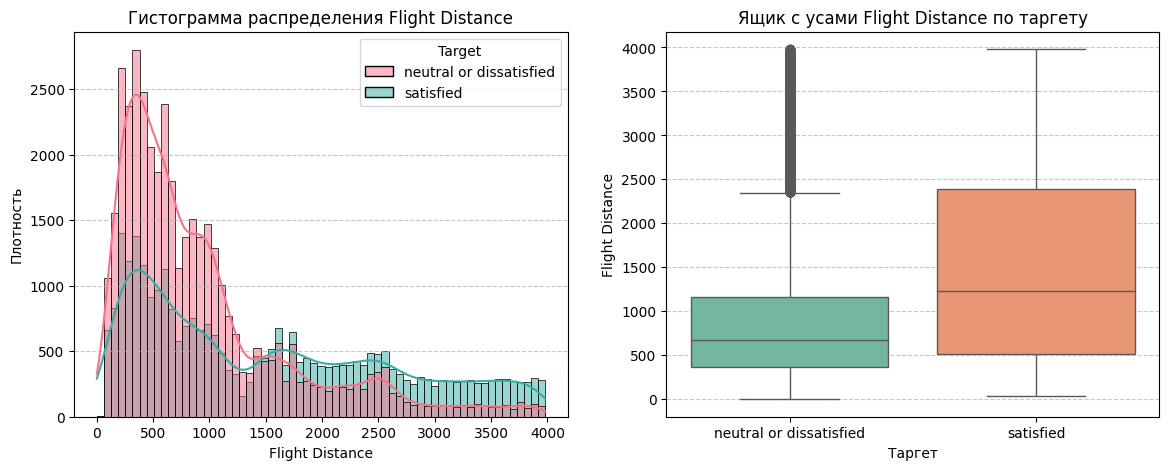

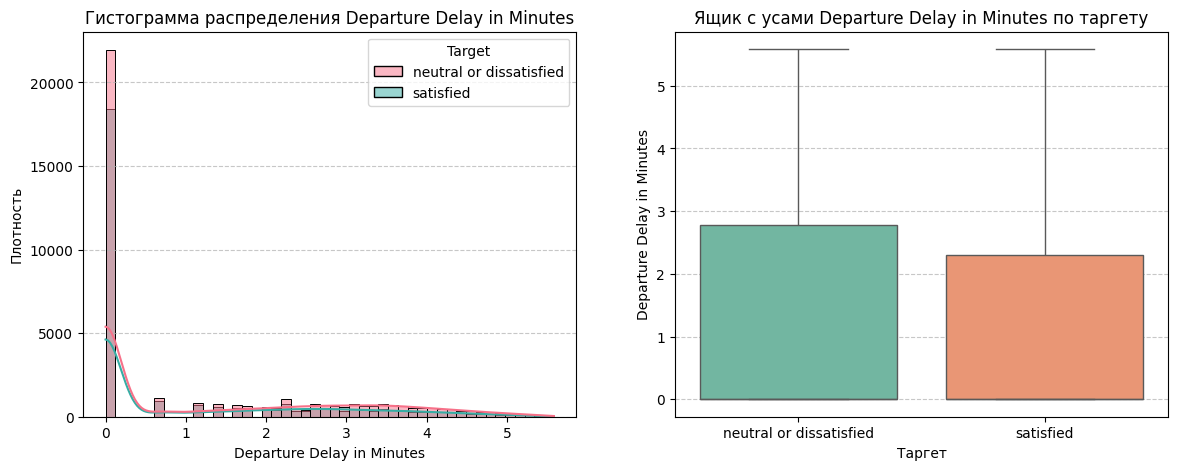

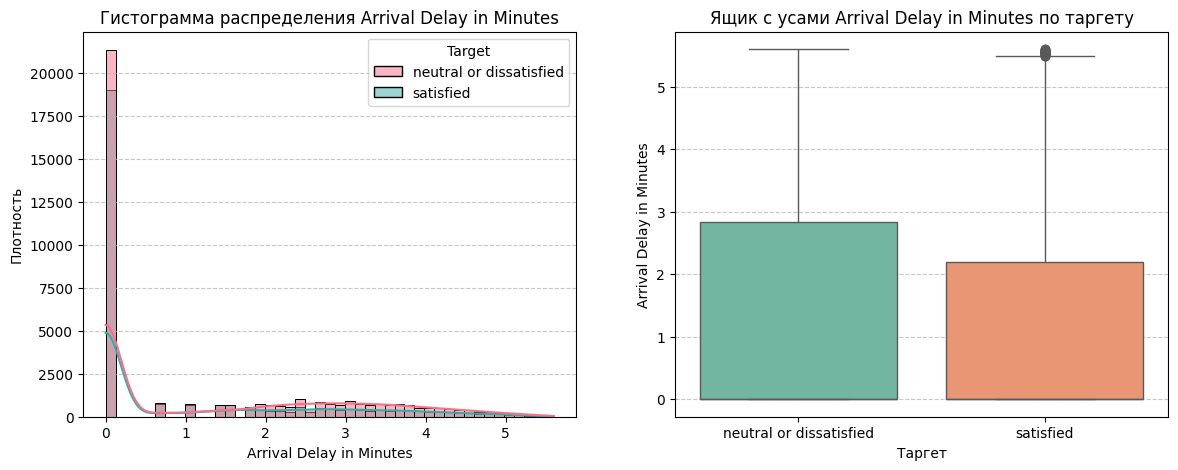

In [57]:
plot_continuous(continuous_cols, X_train, y_train)

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

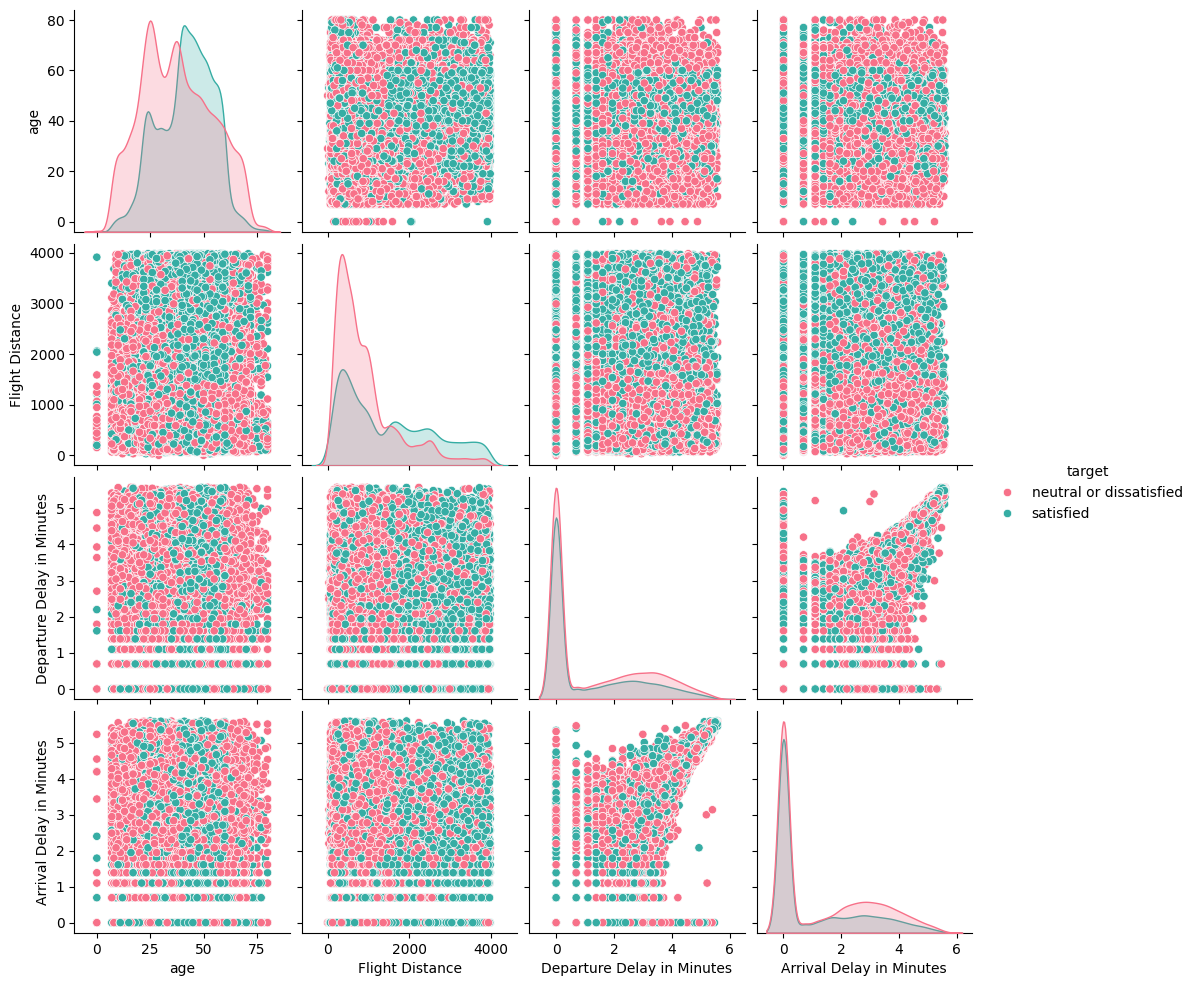

In [58]:
X_cont = X_train[continuous_cols].copy()
X_cont['target'] = y_train.copy()
sns.pairplot(data=X_cont, hue='target', palette="husl")


# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [59]:
y_train = (y_train == 'satisfied')
y_train = y_train.astype(int)
y_val = (y_val == 'satisfied')
y_val = y_val.astype(int)

In [60]:
y_train.head()


id
2031     0
11597    1
74668    0
31602    0
51518    1
Name: satisfaction, dtype: int64

In [61]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False, drop='first')
one_hot_encoded = enc.fit_transform(X_train[categorical_cols])

data_cat_enc = pd.DataFrame(one_hot_encoded, columns=enc.get_feature_names_out(categorical_cols), index=X_train.index)

data_enc = pd.concat([X_train, data_cat_enc], axis=1)

data_enc = data_enc.drop(categorical_cols, axis=1)

In [62]:
data_enc


age  Flight Distance  Departure Delay in Minutes  \
id                                                          
2031    29.0            785.0                    0.000000   
11597   45.0           3269.0                    0.000000   
74668    8.0           1431.0                    0.000000   
31602   48.0            602.0                    0.000000   
51518   25.0            651.0                    0.000000   
...      ...              ...                         ...   
63360   25.0            337.0                    0.000000   
29678   77.0           1448.0                    0.000000   
118743  31.0            304.0                    3.091042   
8922    45.0            661.0                    0.000000   
28513   55.0           1359.0                    0.000000   

        Arrival Delay in Minutes  Inflight wifi service  \
id                                                        
2031                    0.000000                    2.0   
11597                   0.000000                    0.0   
74668                   0.000000                    3.0   
31602                   0.000000                    4.0   
51518                   0.000000                    5.0   
...                          ...                    ...   
63360                   0.000000                    1.0   
29678                   0.000000                    2.0   
118743                  2.564949                    4.0   
8922                    0.000000                    4.0   
28513                   0.000000                    3.0   

        Departure/Arrival time convenient  Ease of Online booking  \
id                                                                  
2031                                  2.0                     2.0   
11597                                 0.0                     0.0   
74668                                 1.0                     3.0   
31602                                 5.0                     4.0   
51518                                 0.0                     5.0   
...                                   ...                     ...   
63360                                 4.0                     1.0   
29678                                 5.0                     5.0   
118743                                4.0                     4.0   
8922                                  1.0                     4.0   
28513                                 3.0                     3.0   

        Gate location  Food and drink  Online boarding  ...  Leg room service  \
id                                                      ...                     
2031              4.0             4.0              2.0  ...               3.0   
11597             3.0             2.0              2.0  ...               3.0   
74668             2.0             5.0              3.0  ...               5.0   
31602             3.0             2.0              5.0  ...               4.0   
51518             2.0             2.0              5.0  ...               1.0   
...               ...             ...              ...  ...               ...   
63360             4.0             4.0              1.0  ...               4.0   
29678             5.0             2.0              2.0  ...               2.0   
118743            1.0             1.0              4.0  ...               3.0   
8922              4.0             2.0              4.0  ...               3.0   
28513             3.0             3.0              3.0  ...               1.0   

        Baggage handling  Checkin service  Inflight service  cleanliness  \
id                                                                         
2031                 5.0              4.0               5.0          4.0   
11597                3.0              5.0               3.0          1.0   
74668                2.0              2.0               1.0          5.0   
31602                2.0              3.0               4.0          3.0   
51518                2.0              3

In [63]:
X_train = data_enc

In [64]:
one_hot_encoded = enc.transform(X_val[categorical_cols])

data_cat_enc = pd.DataFrame(one_hot_encoded, columns=enc.get_feature_names_out(categorical_cols), index=X_val.index)

data_enc = pd.concat([X_val, data_cat_enc], axis=1)

data_enc = data_enc.drop(categorical_cols, axis=1)

X_val = data_enc

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [65]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [66]:
y_pred = dtc.predict(X_val)

In [67]:
print(accuracy_score(y_val, y_pred))

0.9413495488426834


## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [68]:
# Ваш код ниже — дополните его
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        dtc, X_train.values, y_train.values, X_val.values, y_val.values,
        loss='0-1_loss',
        random_seed=42)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.062
Average bias: 0.041
Average variance: 0.046


### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [69]:
print(dtc.get_depth())

31


In [70]:
print(dtc.get_n_leaves())

2095


### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

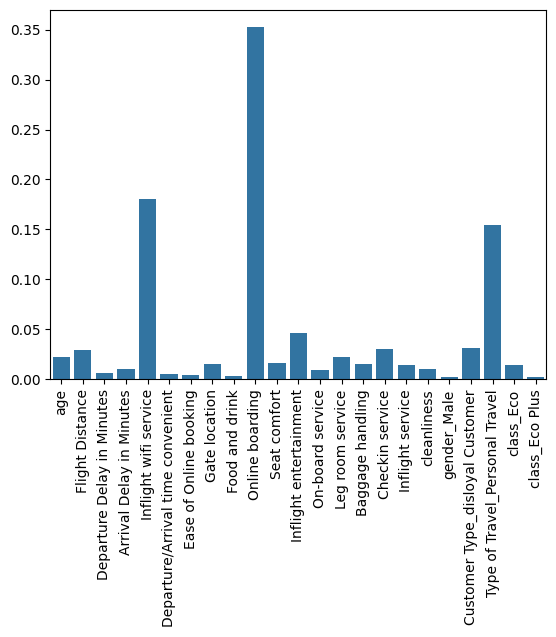

In [71]:
features = pd.Series(dtc.feature_importances_, index=X_train.columns)
sns.barplot(features)
plt.xticks(rotation=90)
plt.show()



```
Самыми информативными оказались признаки Inflight wifi service, Online boarding, Type of Travel_Personal Travel
```



### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [72]:
dtc = DecisionTreeClassifier(max_depth=5)
features=['Inflight wifi service', 'Online boarding']
dtc.fit(X_train[features], y_train)

DecisionTreeClassifier(max_depth=5)

In [73]:
y_pred = dtc.predict(X_val[features])

In [74]:
print(accuracy_score(y_val, y_pred))

0.824833267948215


### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

In [75]:
tree_data = export_graphviz(dtc,
                            class_names=True,
                            filled=True, rounded=True,
                            special_characters=True,
                            out_file=None)
graph = Source(tree_data)

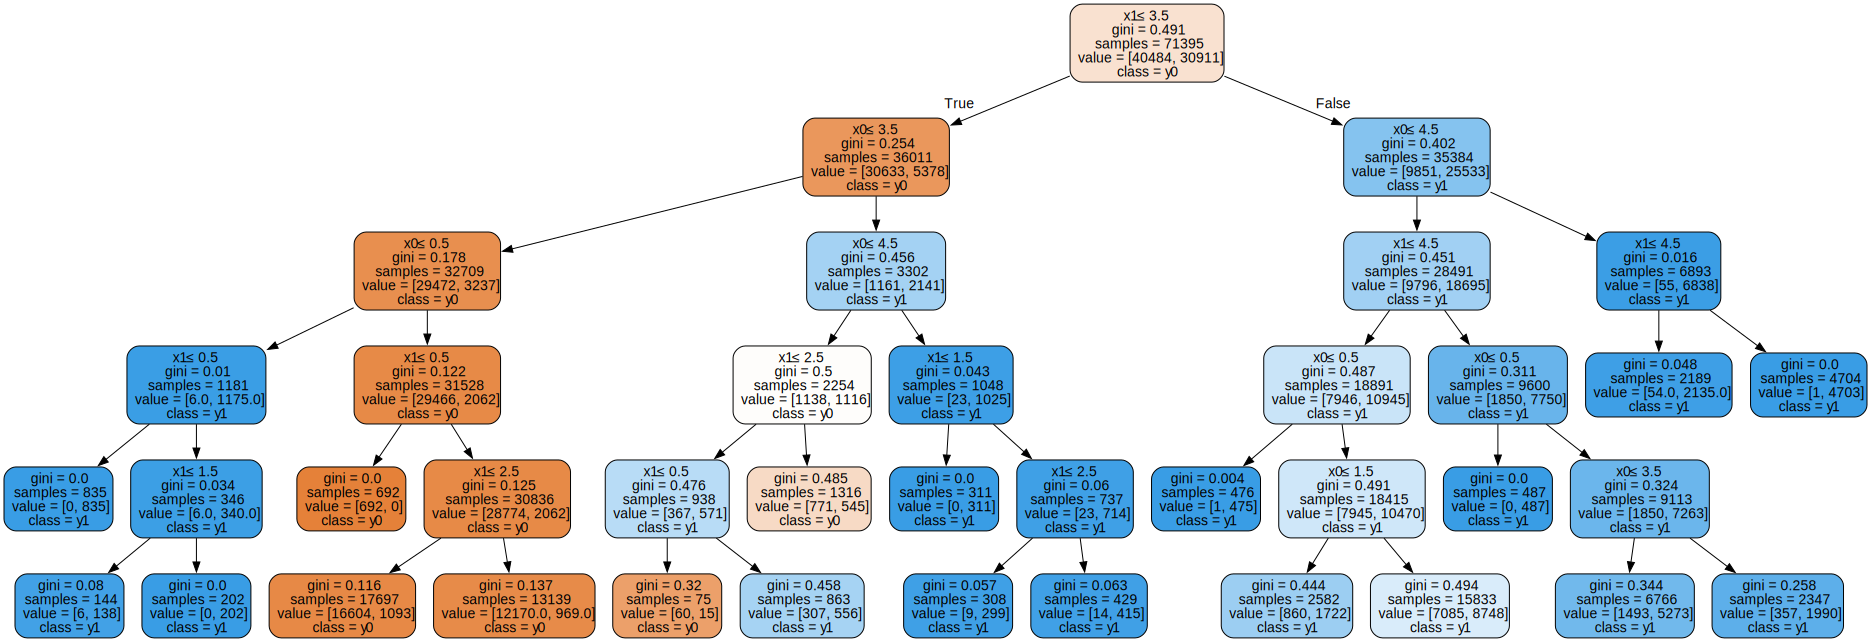

In [76]:
graph

`Предикаты кратны 0.5, потому что разбиение идет по среднему между двумя соседними значениями признака, а они у нас являются целыми числами и отличаются на единицу. То есть среднее между 4 и 5 – это 4.5`

*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

[Text(0.5775862068965517, 0.9166666666666666, 'x[1] <= 3.5\ngini = 0.491\nsamples = 71395\nvalue = [40484, 30911]'),
 Text(0.3103448275862069, 0.75, 'x[0] <= 3.5\ngini = 0.254\nsamples = 36011\nvalue = [30633, 5378]'),
 Text(0.44396551724137934, 0.8333333333333333, 'True  '),
 Text(0.13793103448275862, 0.5833333333333334, 'x[0] <= 0.5\ngini = 0.178\nsamples = 32709\nvalue = [29472, 3237]'),
 Text(0.06896551724137931, 0.4166666666666667, 'x[1] <= 0.5\ngini = 0.01\nsamples = 1181\nvalue = [6.0, 1175.0]'),
 Text(0.034482758620689655, 0.25, 'gini = 0.0\nsamples = 835\nvalue = [0, 835]'),
 Text(0.10344827586206896, 0.25, 'x[1] <= 1.5\ngini = 0.034\nsamples = 346\nvalue = [6.0, 340.0]'),
 Text(0.06896551724137931, 0.08333333333333333, 'gini = 0.08\nsamples = 144\nvalue = [6, 138]'),
 Text(0.13793103448275862, 0.08333333333333333, 'gini = 0.0\nsamples = 202\nvalue = [0, 202]'),
 Text(0.20689655172413793, 0.4166666666666667, 'x[1] <= 0.5\ngini = 0.122\nsamples = 31528\nvalue = [29466, 2062]'),

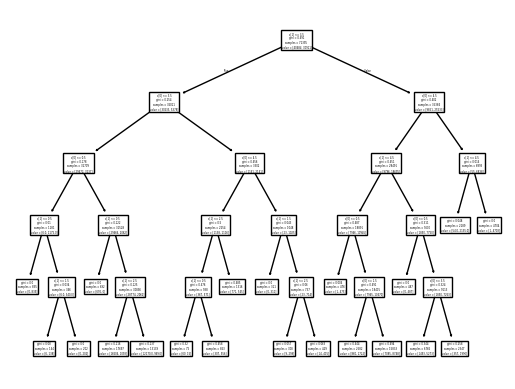

In [77]:
plot_tree(dtc)



```
Дерево не симметрично. Нельзя сказать, что это однозначно плохо, поскольку ассиметрия не такая значительная,
не наблюадется большой разницы в глубине деревьев, что могло бы говорить о переобучении, где дерево очень глубокое.
```



### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Axes: >

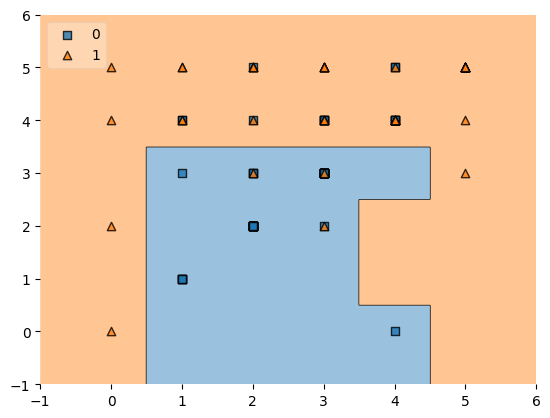

In [78]:
plot_decision_regions(X_train[features][:100].to_numpy(), y_train[:100].to_numpy(), clf=dtc, legend=2)


### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!



```
С переменными из предыдущих пунктов границы никак не меняются.
Либо задание неверно сформулировано, либо я что-то пропустил,
но границы меняются с переменными age и Flight Distance,
а не с переменнымим, по которым мы смотрели коэффициенты
```



/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/utils/validatio

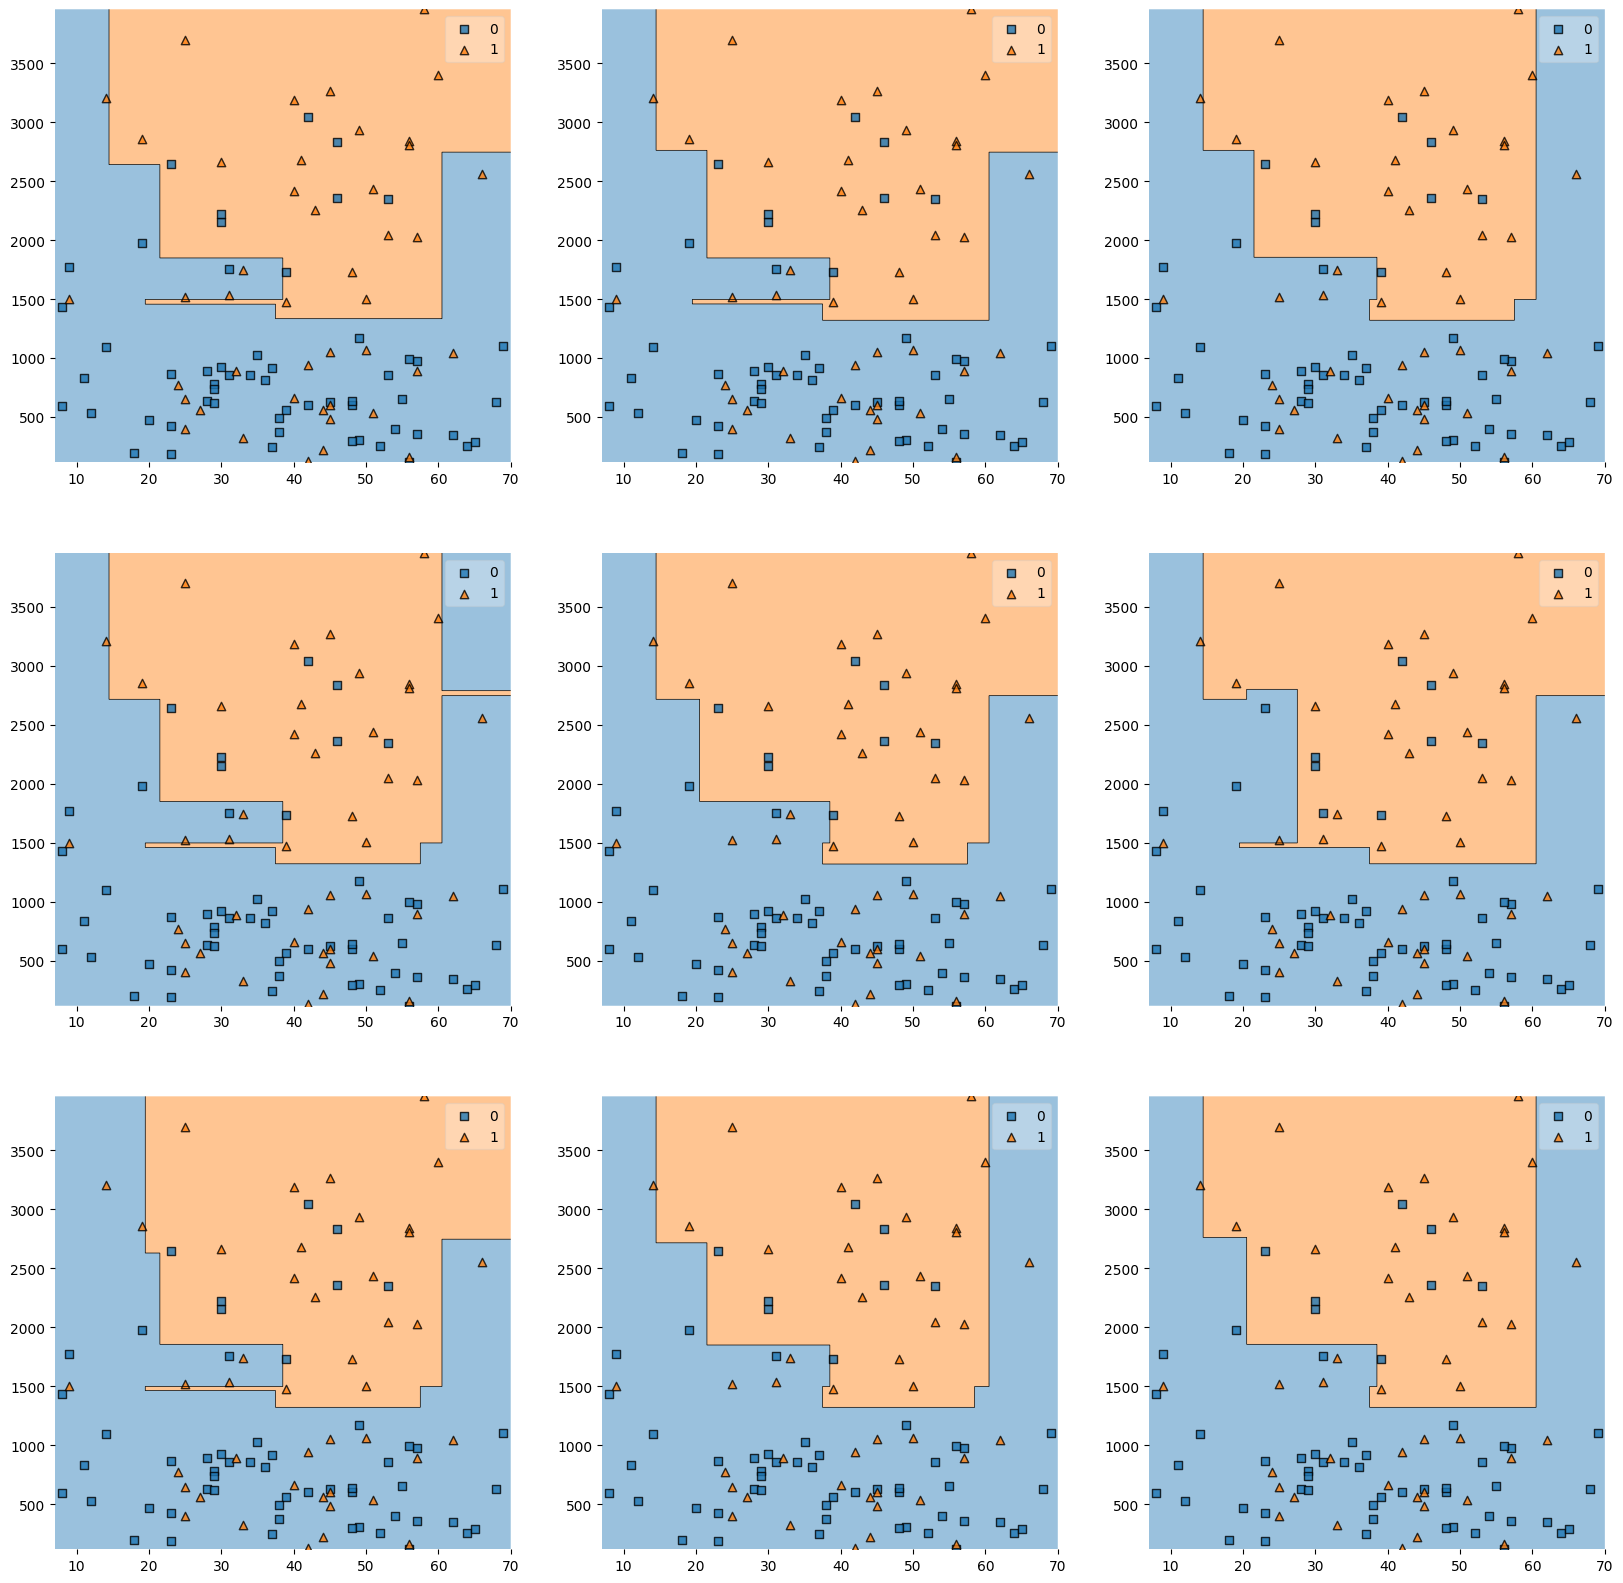

In [79]:
# замените X_train_example на вашу переменную
X_train_example = X_train[['age', 'Flight Distance']]

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 5000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [80]:
%%time
X_train_enc = X_train
X_val_enc = X_val


depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 2.69 s, sys: 77.8 ms, total: 2.77 s
Wall time: 2.82 s


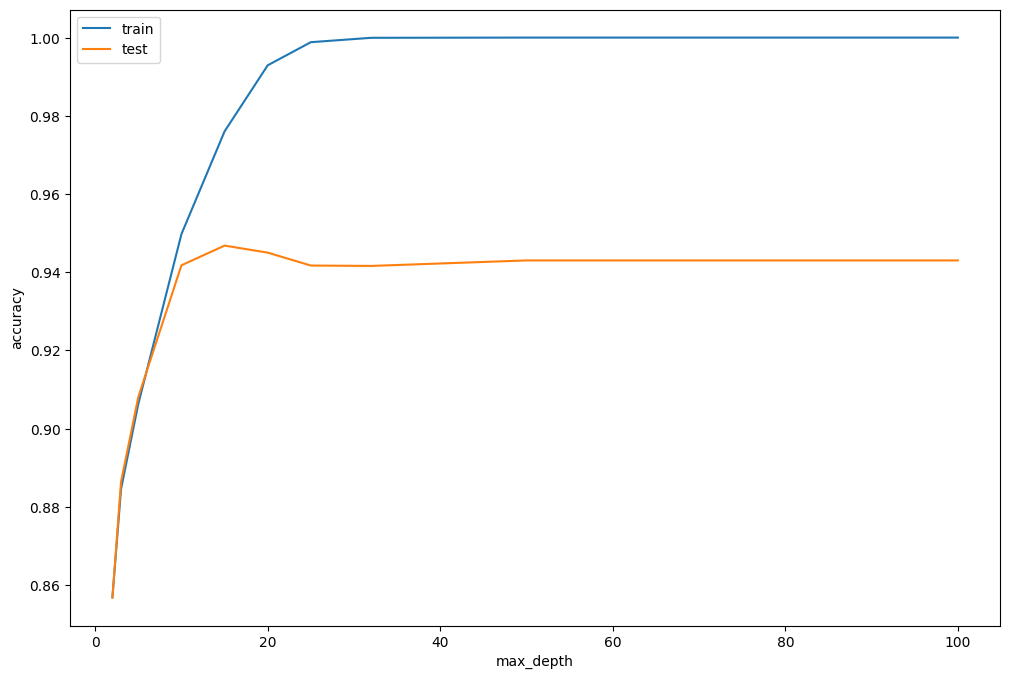

In [81]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [82]:
param_grid = {
    'max_depth': [10, 12, 15, 17, 18],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

gs = GridSearchCV(estimator=DecisionTreeClassifier(),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy')

gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 12, 15, 17, 18],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [83]:
print("Hyperparameters:", gs.best_params_)
print("Accuracy:", gs.best_score_)

Hyperparameters: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 10}
Accuracy: 0.9491280902023952


### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [84]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(gs.best_estimator_,f)


# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [85]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [86]:
y_pred = rf.predict(X_val)

### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

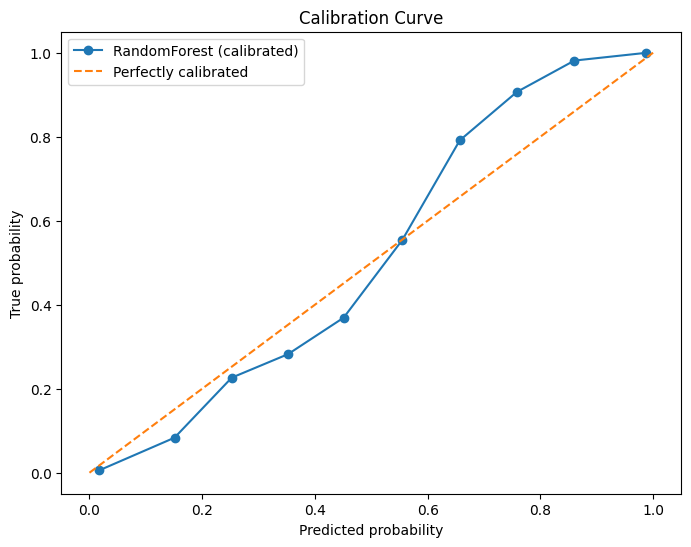

In [87]:
from sklearn.calibration import calibration_curve

y_prob = rf.predict_proba(X_val)[:, 1]

prob_true, prob_pred = calibration_curve(y_val, y_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker="o", label="RandomForest (calibrated)")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()


Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?



```
Деревья не совсем корректно предсказывают вероятности из-за склонности к переобучению
и излишней уверенности модели в прогнозах (overconfidence),
которая возникает из-за разбиения объектов по большому к-ву листьев с маленькими выборками.
```



### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [107]:
lr = LogisticRegression(max_iter=100000, n_jobs=-1, random_state=42)
lr.fit(X_train, y_train)


LogisticRegression(max_iter=100000, n_jobs=-1, random_state=42)

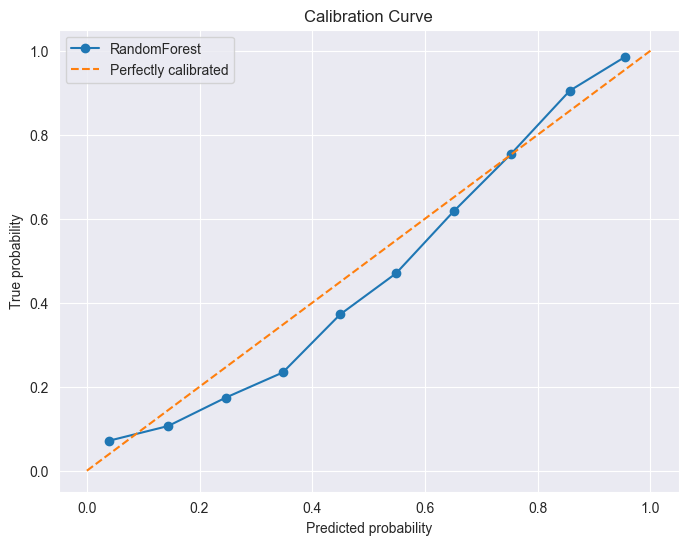

In [108]:
y_prob = lr.predict_proba(X_val)[:, 1]

prob_true, prob_pred = calibration_curve(y_val, y_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker="o", label="RandomForest")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?



```
Логистическая регрессия корректно предсказывает вероятности,
потому что основана на сигмоиде, то есть она заточена на то,
чтобы предсказывать вероятность.
Так же ее штрафует за переуверенность log-loss (логистическая функция потерь),
то есть неверно предсказанные вероятности ведут к очень большой ошибке.
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [109]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [110]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

rf_logreg = CalibratedClassifierCV(rf, cv=5, method='sigmoid')
rf_logreg.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(n_jobs=-1,
                                                        random_state=42))

In [111]:
rf_isotonic = CalibratedClassifierCV(rf, cv=5, method='isotonic')
rf_isotonic.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(n_jobs=-1,
                                                        random_state=42),
                       method='isotonic')

In [112]:
probs_rf = rf.predict_proba(X_val)[:, 1]
probs_logreg = rf_logreg.predict_proba(X_val)[:, 1]
probs_isotonic = rf_isotonic.predict_proba(X_val)[:, 1]

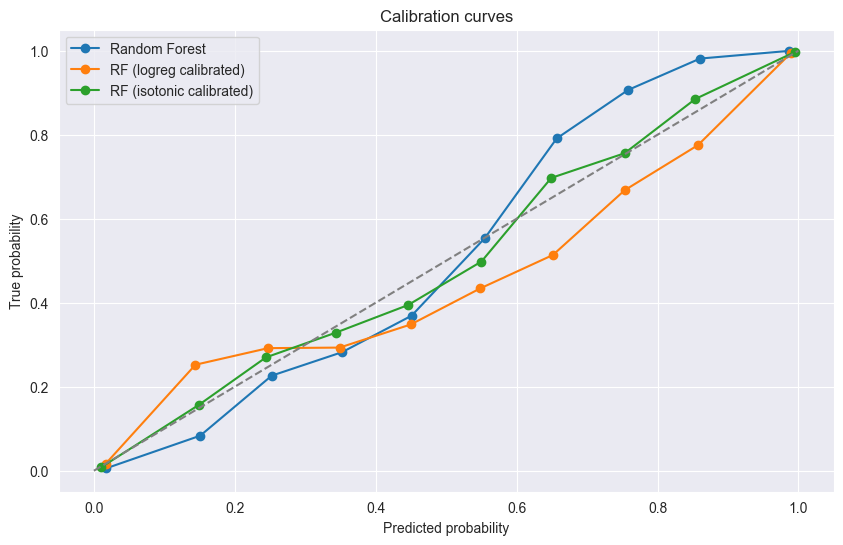

In [113]:
plt.figure(figsize=(10, 6))
for probs, label in zip([probs_rf, probs_logreg, probs_isotonic],
                         ['Random Forest', 'RF (logreg calibrated)', 'RF (isotonic calibrated)']):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_val, probs, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=label)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.legend()
plt.title('Calibration curves')
plt.show()



```
Калибровка изотонической регрессией снизила переоценку низких вероятностей и недооценку высоких вероятностей.
Калибровка логистической регресиией привела к обратному результату:
переоценка высоких вероятностей и недооценка низких.
Возможно, нужно поработать с параметрами калибровки.
```



### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)




```
Histogram Binning for classification – разбиение данных на "бины",
в каждом из которых оценивается вероятность положительного исхода.

Bayesian Binning into Quantiles (BBQ) – тоже разбиение данных на "бины",
но сразу несколькими способами, и с усреднением по результатам.

Beta Calibration for classification and object detection – модифицированная версия калибровки логистической регрессией,
но с добавочными параметрами a и b, которые позволяют смещать и изменять кривизну функции.
Если a и b равны 0, то метод сводится к классической логистической регрессии (сигмиоида).
```



[Netcal - библиотека с калибровочными методами на Python](https://efs-opensource.github.io/calibration-framework/build/html/index.html#methods)



### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [114]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        rf, X_train.values, y_train.values, X_val.values, y_val.values,
        loss='0-1_loss',
        random_seed=42,
        num_rounds=50)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.041
Average bias: 0.039
Average variance: 0.009



```
Общая ошибка у случайного леса меньше,
смещение сопоставимо, а разброс значительно меньше.
Это ожидаемый результат, так как одиночное дерево менее стабильно, чем лес,
в котором усредняются результаты множества деревьев, снижая разброс.
```

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [115]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        lr, X_train.values, y_train.values, X_val.values, y_val.values,
        loss='0-1_loss',
        random_seed=42,
        num_rounds=50)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.124
Average bias: 0.124
Average variance: 0.004


```
Высокое смещение, разброс немного меньше, чем у случайного леса.
Высокое смещение обусловлено линейностью и простотой модели,
нелинейные зависимости не учитываются.
```

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [123]:
from scipy.stats import uniform, randint

clf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(2, 20),
    'min_samples_split': uniform(0.01, 0.19),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

rs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=params,
    n_iter=50,
    cv=5,
    random_state=42,
    scoring='accuracy',
    n_jobs=-1
)


rs.fit(X_train, y_train)

print("Best params: ", rs.best_params_)
print("Best result: {:.3f}".format(rs.best_score_))

test_accuracy = rs.score(X_val, y_val)
print("Accuracy: {:.3f}".format(test_accuracy))


/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
50 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/bigboss/P

Best params:  {'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': np.float64(0.013033587921840697), 'n_estimators': 139}
Best result: 0.932
Accuracy: 0.935


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [125]:
# замените X_train_enc на ваш трейн
X_train_enc = X_train

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42, n_jobs=-1)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/bigboss/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/bigboss/PyCharmMiscProjec

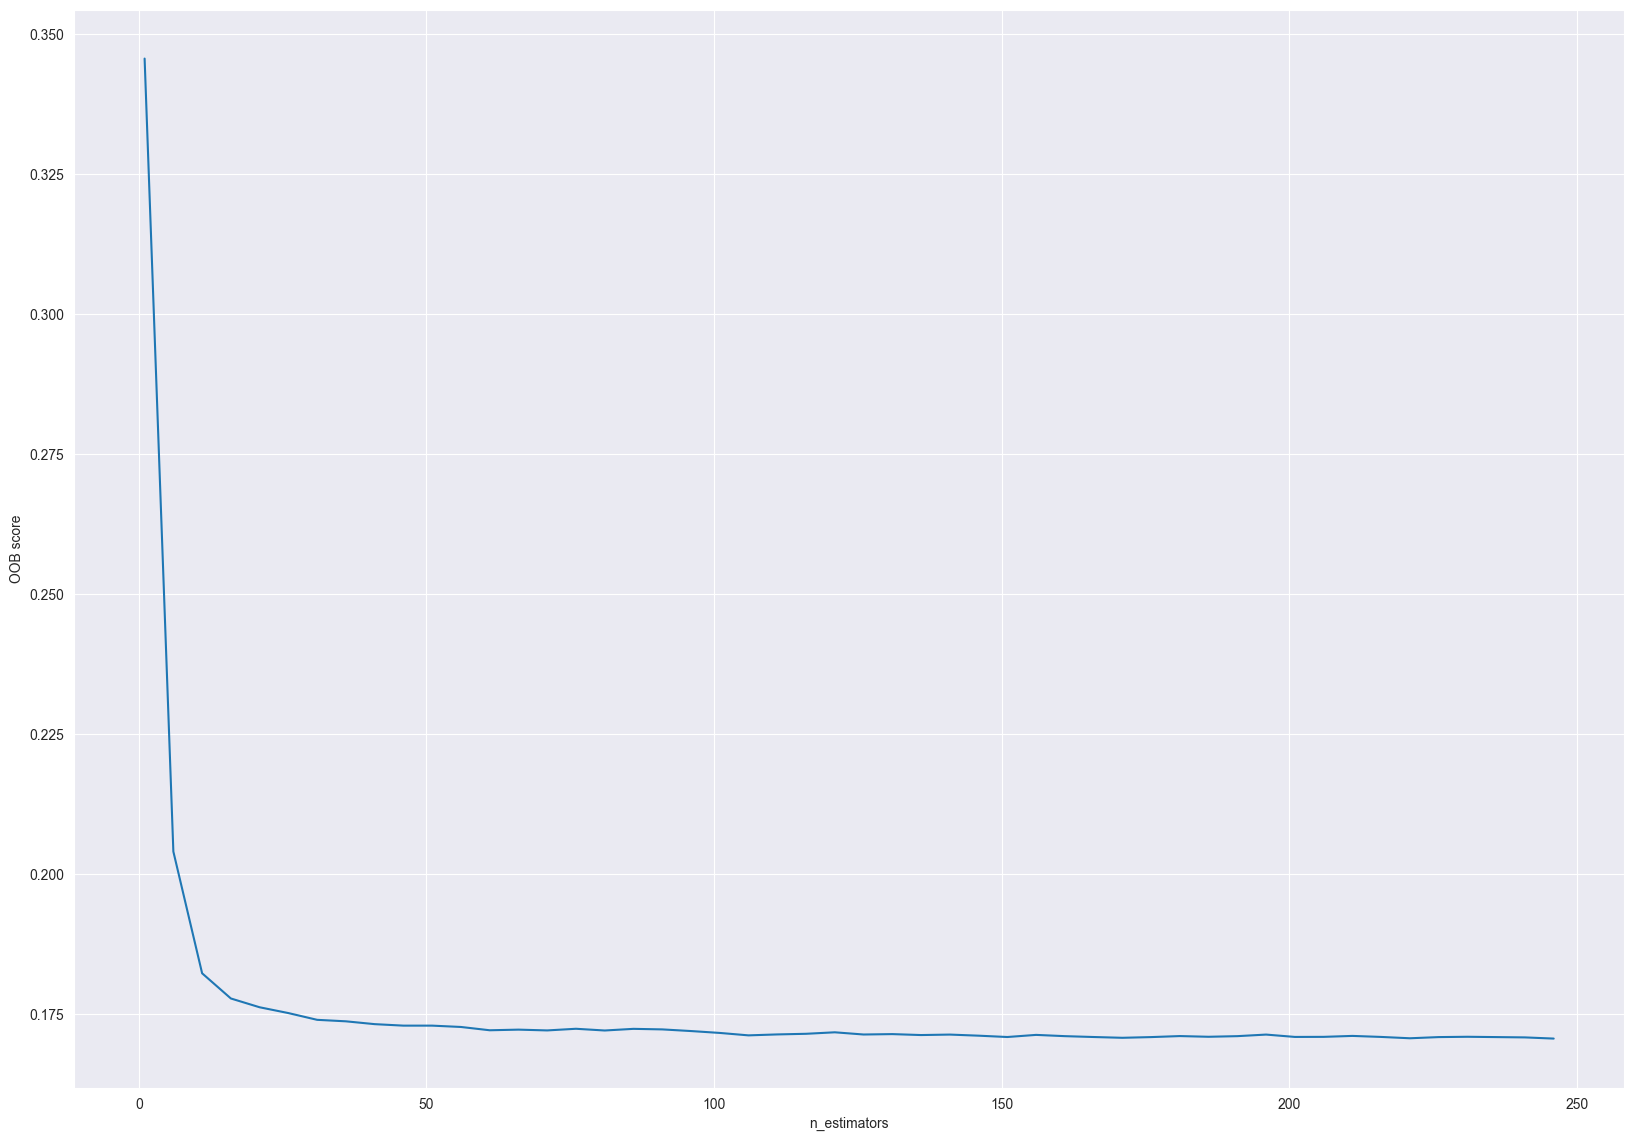

In [126]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [128]:
rf_importances = rs.best_estimator_.feature_importances_

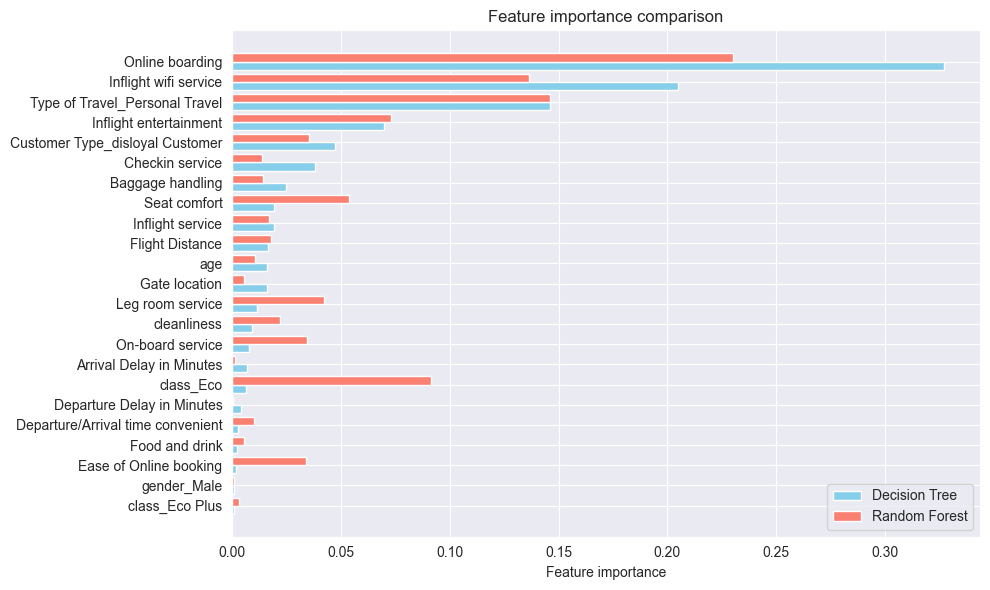

In [131]:
features = X_train.columns
dt_importances = gs.best_estimator_.feature_importances_

indices = np.argsort(dt_importances)

plt.figure(figsize=(10, 6))

width = 0.4
x = np.arange(len(features))

plt.barh(x - width/2, dt_importances[indices],
         height=width, color='skyblue', label='Decision Tree')
plt.barh(x + width/2, rf_importances[indices],
         height=width, color='salmon', label='Random Forest')

plt.xlabel('Feature importance')
plt.yticks(x, features[indices])
plt.title('Feature importance comparison')
plt.legend()
plt.tight_layout()
plt.show()

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [134]:
with open('RFC.pkl', 'wb') as f:
    pickle.dump(rs.best_estimator_,f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [146]:
import shap
import numpy as np

n_samples = 2000
if X_train.shape[0] > n_samples:
    idx = np.random.choice(range(X_train.shape[0]), size=n_samples, replace=False)
    X_sample = X_train.iloc[idx, :].copy()
else:
    X_sample = X_train.copy()

rf = rs.best_estimator_
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)
sv_class1 = shap_values[1]

In [148]:
print(len(shap_values))
print(shap_values[0].shape)
print(shap_values[1].shape)

2000
(23, 2)
(23, 2)


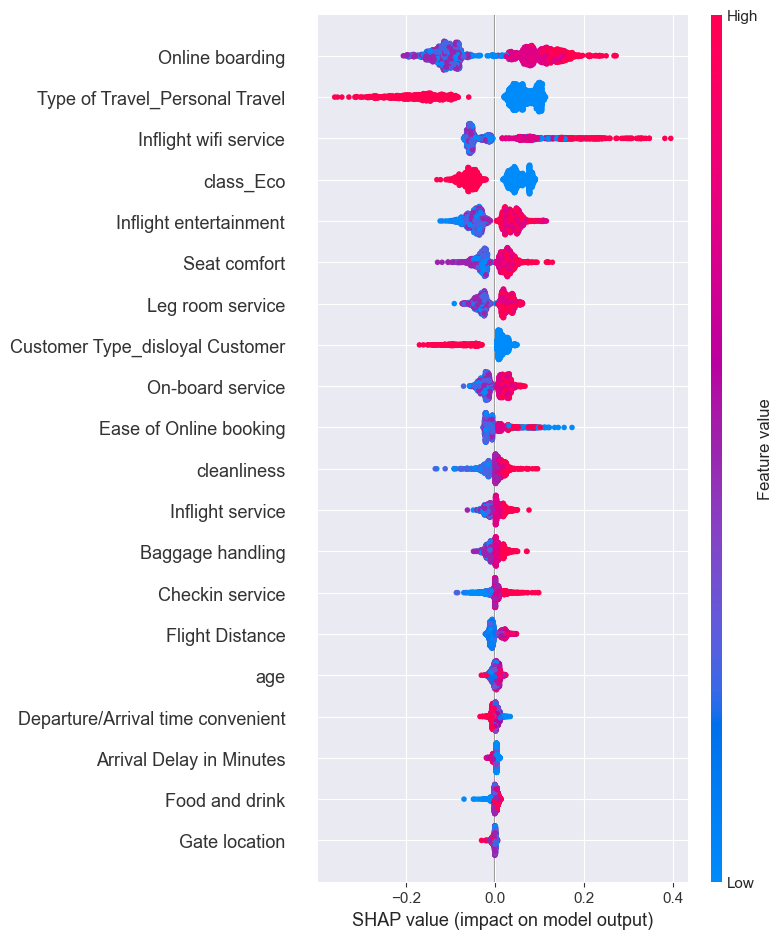

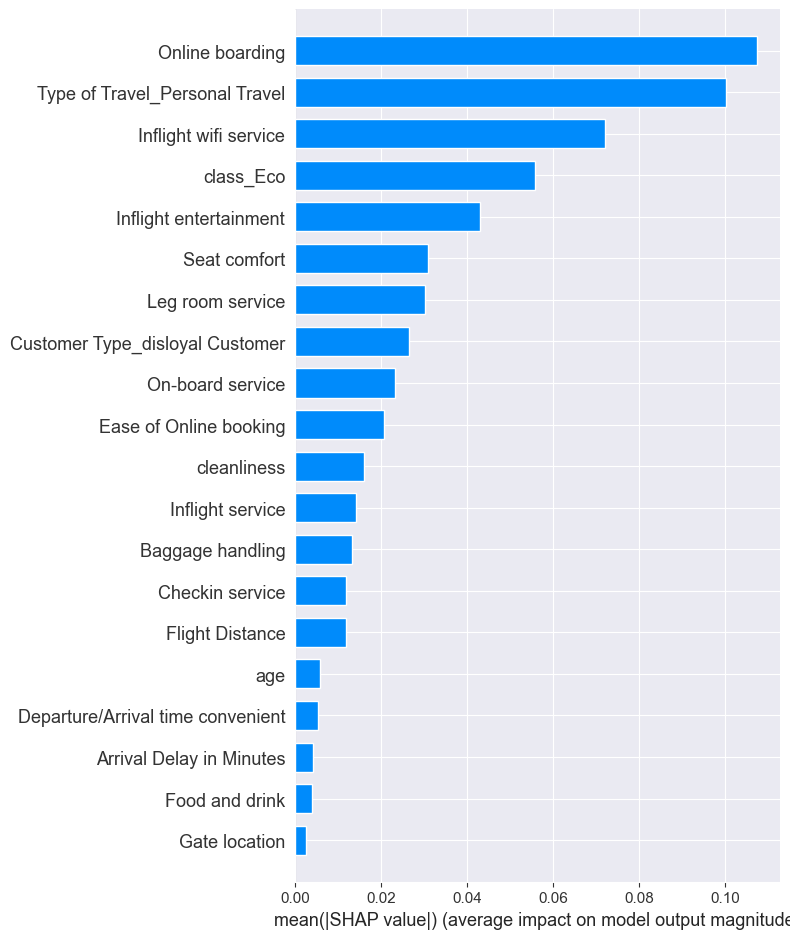

In [149]:
sv_class1 = np.stack([vals[:, 1] for vals in shap_values], axis=0)
shap.summary_plot(sv_class1, X_sample)
shap.summary_plot(sv_class1, X_sample, plot_type="bar")

`В полученном графике признаки расположены по важности по убыванию`\
`Три самых важных признака: Online Boarding, Type of Travel_Personal Travel, Inflight wifi service`\
`Например, выскокие значения Online Boarding сильно повышают вероятность положительного класса, о чем говорят скопления розовых точек справа`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [122]:
# Ваш код здесь


`Ваш ответ здесь`

## Котобонус!

0.25 балла

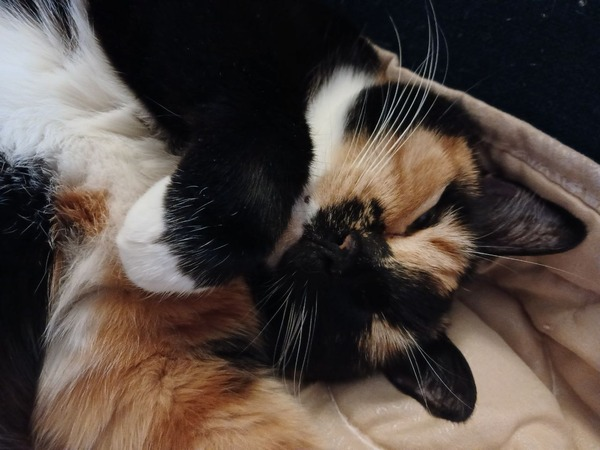

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?